## requirements

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install amg
!pip install python-igraph
!pip install faiss-cpu
!pip install hnswlib
!pip install annoy
!pip install leidenalg
!pip install nmslib 
!pip install datasketch -U
!pip install umap-learn

In [3]:
!cp drive/My\ Drive/MOUSE_RNASeq/270K_rmbatch/* ./
!cp drive/My\ Drive/MOUSE_RNASeq/100K_tablusmuris/* ./
!unzip -q MouseCellAtlas*.zip
!unzip -q MCA100K.zip
!cp -r drive/My\ Drive/HUMAN_RNASeq/68KPBMC/ ./

In [ ]:
!cp -r drive/MyDrive/MOUSE_RNASeq/Neuron_1300K/ ./

##Imports

In [4]:
import os
import time
import tables
import sklearn
import h5py
import scipy as sp
import numpy as np
import numba as nb
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy.sparse as sparse
from PIL import Image
from umap import UMAP
from igraph import Graph
from scipy.stats import variation
from matplotlib import pyplot as plt
from sklearn.cluster import *
from sklearn.neighbors import KernelDensity
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import NearestNeighbors
from scipy.stats import gmean, spearmanr, pearsonr
from scipy.spatial.distance import cosine, correlation, squareform
from scipy.spatial.distance import cdist as sp_cdist
from scipy.spatial.distance import pdist as sp_pdist
from statsmodels.genmod.families.links import identity
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE 
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.utils.sparsefuncs import csc_median_axis_0
from sklearn.utils import issparse
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn import cluster, datasets, mixture
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.utils.sparsefuncs import mean_variance_axis
from collections import defaultdict, Counter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [6]:
## unsupervised clustering loss from https://github.com/XifengGuo/DEC-keras/blob/master/metrics.py, paper: Deep Embedded Clustering, Junyuan Xie et al. 2016
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
nmi = normalized_mutual_info_score
ari = adjusted_rand_score
ami = adjusted_mutual_info_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_assignment(w.max() - w)
    return sum([w[ind[0][i], ind[1][i]] for i in range(len(ind[0]))]) * 1.0 / y_pred.size

In [7]:
"""
NMI, PS, ARI, ACC, AMI = [],[],[],[], []
for i in range(1000):
    a = np.random.randint(0, np.random.randint(30,50, 1), 1000)
    b = a+np.random.randint(0,2, size = 1000)*np.random.randint(0,2, size = 1000)*np.random.randint(0, 10, 1000)
    NMI.append(nmi(a,b))
    PS.append(purity_score(a,b))
    ARI.append(ari(a,b))
    ACC.append(acc(a,b))
    AMI.append(ami(a,b))
"""

'\nNMI, PS, ARI, ACC, AMI = [],[],[],[], []\nfor i in range(1000):\n    a = np.random.randint(0, np.random.randint(30,50, 1), 1000)\n    b = a+np.random.randint(0,2, size = 1000)*np.random.randint(0,2, size = 1000)*np.random.randint(0, 10, 1000)\n    NMI.append(nmi(a,b))\n    PS.append(purity_score(a,b))\n    ARI.append(ari(a,b))\n    ACC.append(acc(a,b))\n    AMI.append(ami(a,b))\n'

In [8]:
sns.set(rc={'figure.figsize':(6, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams["axes.grid"] = False

In [9]:
!pip install fbpca
import fbpca

  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11376 sha256=e686b604efbea95dc20f5b309f73b27925f0521b3aa25d62600fc8d78fa53822
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
Successfully built fbpca


## Read File Functions

In [10]:
def readh5(file):
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    shape=getattr(mat_group, 'shape').read()
    genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
    barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
    indptr=getattr(mat_group, 'indptr').read()
    data = getattr(mat_group, 'data').read()
    indices = getattr(mat_group, 'indices').read()
    matrix = sparse.csc_matrix((data, indices, indptr), shape=shape, )
    return matrix, genes, barcodes

In [ ]:
d, i, p , shape = h52memmap('./Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5','mm10')

In [ ]:
%timeit np.concatenate([d[i*2000:(i+1)*2000] for i in np.random.randint(0, 1300000, 50000)])

The slowest run took 23.56 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.25 s per loop


In [ ]:
import numpy as np

In [ ]:
np.arange(10000000)

array([      0,       1,       2, ..., 9999997, 9999998, 9999999])

In [ ]:
%timeit np.array(np.arange(10000000))

10 loops, best of 5: 20.5 ms per loop


In [ ]:
randomReadSparse(d, i ,p, np.arange(100000))

done


<100000x27998 sparse matrix of type '<class 'numpy.int32'>'
	with 197980827 stored elements in Compressed Sparse Row format>

In [11]:
# This function puts h5 stored scipy sparse matrices onto memap to reduce memory load
# Use only when matrix size exceeds 300,000
def h52memmap(file, group = 'matrix', ind_file = 'temp_ind', data_file = 'temp_ind'):
    import h5py
    f = h5py.File(file)
    grp = f[group]
    assert 'data' in grp.keys() and 'indices' in grp.keys() and 'indptr' in grp.keys() and 'shape' in grp.keys()
    d_type = np.int32
    if np.log2(min(grp['shape'])) < 16: d_type = np.int16
    if os.path.exists(data_file):
        data0 = np.memmap(data_file, dtype=grp['data'].dtype, mode='r+', shape=grp['data'].shape)
    else:
        data0 = np.memmap('temp_data', dtype=grp['data'].dtype, mode='w+', shape=grp['data'].shape)
        data0[:] = grp['data'][:]
    if os.path.exists(ind_file):
        indices0 = np.memmap(ind_file, dtype=d_type, mode='r+', shape=grp['indices'].shape)
    else:
        indices0 = np.memmap('temp_ind', dtype=d_type, mode='w+', shape=grp['indices'].shape)
        indices0[:] = grp['indices'][:]
    indptr = grp['indptr']
    shape = np.array(grp['shape'])
    shape = np.array([max(shape), min(shape)])
    return data0, indices0, indptr, shape

# quick but maybe not quickest way to sample from memmaped data and indices (best I could come up with given the time)
# memomry load is low though
def randomReadSparse(data, indices, indptr, rinds):
    rinds = np.sort(rinds)
    block_size = min(300000, max(rinds))
    new_indices = []
    new_indptr = [0]
    new_data = []
    t = 0
    total_size = 0
    while total_size < max(rinds)+1:
        st0 = indptr[total_size]
        end0 = indptr[min(total_size+block_size, len(indptr)-1)]
        s = time.time()
        new_rinds = rinds[np.array(rinds >= total_size) & np.array(rinds < total_size+block_size)]
        new_rinds -= total_size
        s = time.time()
        data0 = data[st0:end0]
        ind0 = indices[st0:end0]
        indptr0 = indptr[total_size:total_size+block_size+1]
        for i in np.arange(len(new_rinds)):
            st = indptr0[new_rinds[i]]
            end = indptr0[new_rinds[i]+1]
            t += end - st
            new_indices.append(indices[st:end])
            new_data.append(data[st:end])
            new_indptr.append(t)
        total_size += block_size
    print('done')
    new_data = np.concatenate(new_data)
    new_indices = np.concatenate(new_indices)
    return sparse.csr_matrix((new_data,new_indices, np.array(new_indptr)))

## h5 tests

In [ ]:
hgenes = np.load('./Neuron_1300K/HighVariableGeneIndex_2.npy')

In [ ]:
inds = np.memmap('temp_ind', dtype = np.int16, mode='r+', order = 'F')

In [ ]:
datas = np.memmap('temp_data', dtype = np.int32, mode='r+', order = 'F')

In [ ]:
indptrs = f['mm10']['shape']

In [ ]:
indptrs = np.array(indptrs)

In [ ]:
a = np.random.randint(0, 1300000, size = 50000)

In [ ]:
pca_2m = []
m =0
while m < max(f['mm10']['shape']):
    pca_2m.append(tsvd.transform(randomReadCSC(datas, inds, indptrs, np.arange(m, min(m+100000, max(f['mm10']['shape']))))))
    m += 100000
pca_2m = np.vstack(pca_2m)

In [ ]:
pca_1m = []
m =0
while m < max(f['mm10']['shape']):
    pca_1m.append(tsvd.transform(randomReadCSC(datas, inds, indptrs, np.arange(m, min(m+100000, max(f['mm10']['shape']))))))
    m += 100000
pca_1m = np.vstack(pca_1m)

In [ ]:
pca_2m.shape

In [ ]:
Counter(test_pca_clust[2])

In [ ]:
tsvd = TruncatedSVD(100)

In [ ]:
tsvd.fit(sub_data)

In [ ]:
tsvd.transform(sub_data).shape

In [ ]:
test_pca = DataBag(data = pca_2m, umap_transform=False)
test_pca.randomSplit(min_size = 50000)

In [ ]:
import h5py
f = h5py.File('./Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5')

In [ ]:
np.sum(tsvd.explained_variance_ratio_)

In [ ]:
import h5py
f = h5py.File('./Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5')
test = DataBag(h5File = './Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5', h5 = True, group = 'mm10')

In [ ]:
s=time.time()
clusterDataBag(test_pca, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
test_pca_clust = clusterMerge(test_pca.data_packs, merge = 'louvain')

In [ ]:
Counter(test_pca_clust[2])

In [ ]:
umap = UMAP(n_components=2)

In [ ]:
a = umap.fit_transform(pca_2m)

In [ ]:
sns.scatterplot(x=test_pca.data_vis[:,0], y=test_pca.data_vis[:, 1], hue=[int(i) for i in test_pca_clust[2]], s=12, edgecolor="none")

In [ ]:
s=time.time()
clusterDataBag(test, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim, features = hgenes)
print(time.time()-s)

## Data Containers

In [12]:
#@nb.jit(nopython=True)
def getClusterMean(data, label):
    centers = []
    for i in np.arange(0, np.max(label)+1):
        inds = np.where(label == i)[0]
        data_ = data[inds,:]
        cnt = data_.mean(axis=0) if not issparse(data) else np.array(data_.mean(axis=0))[0]
        centers.append((cnt, inds))
    return centers

@nb.jit(nopython=True)
def getClusterMedian(data, label):
    centers = []
    for i in np.arange(0, np.max(label)+1):
        inds = np.where(label == i)[0]
        data_ = data[inds,:]
        cnt = np.zeros(data_.shape[1])
        for i in np.arange(data_.shape[1]):
            cnt[i] = np.median(data_[:,i])
        centers.append((cnt, inds))
    return centers 
        
class DataPack:
    def __init__(self, data, indices, label=None, h5 = False):
        self.data = data
        self.sparse = issparse(data)
        self.indices = indices
        self.label = label
        self.cluster = False if np.any(label) == None else True
        self.h5 = h5
    def set_labels(self, label, min_limit=2):
        assert sorted([int(i) for i in set(label)]) == list(range(int(min(label)),int(max(label))+1)), 'All instance of label must be integers that are consecutive'
        assert min(label) == 0 or min(label) == -1
        label = np.array(label)
        #print(Counter(label))
        i=0
        while i <= max(label):
            if len(np.where(label == i)[0]) < min_limit:
                label[label == i] = -1
                label[label > i] = label[label > i]-1
            else:
                i +=1
        #print(Counter(label))
        self.label = label
        self.cluster = True
        #self.centerBylabel()
        
    def fullData(self):
        return self.data

    def getData(self, asarrays=True, features = None):
        if self.h5:
            data = randomReadCSC(self.data[0], self.data[1], self.data[2], self.indices)
            data = data[:, features] if np.all(features != None) else data
            return data
        #if self.sparse and asarrays:
            #return self.data[self.indices,:].toarray()
        data= self.data[self.indices, features] if np.all(features != None) else self.data[self.indices,:]
        return data
    
    def sampleBylabel(self, data = None, proportion = 0.1, bootstrap=False):
        data0 = self.getData() if np.any(data) == None else data
        assert self.cluster == True, 'UnlabeledError: Please set labels for data first'
        min_size = self.label.shape[0]*proportion/np.max(self.label)
        indices= [np.random.choice(np.where(self.label == i)[0], 
                                   size=int(np.max([min_size, int(len(np.where(self.label == i)[0])*proportion)])),
                                   replace=True if int(len(np.where(self.label == i)[0])) < min_size else False) for i in range(0, np.max(self.label)+1)]
        sizes = [[i]*len(indices[i]) for i in range(len(indices))]
        indices, sizes = np.hstack(indices), np.hstack(sizes)
        self.data_s = data0[indices,:]
        self.sample_l = sizes
        return self.data_s, self.sample_l
    
    def centerBylabel(self, data = None, center=None, median=False):
        assert self.cluster == True, 'UnlabeledError: Please set labels for data first'
        
        data0 = self.getData() if np.any(data) == None else data
        s_ = time.time()
        if np.all(center) != None:
            self.label_center = [(center[i]/len(np.where(self.label == i)[0]), np.where(self.label == i)[0]) for i in sorted(range(0, max(self.label)+1)) ]
            return
        #if self.sparse:
            #data = data0.toarray()
            #print('Densify: ', time.time() - s_)
        #if not median:
        self.label_center = getClusterMean(data0, self.label)#[(method(data[self.label == i,], axis=0), data0[self.label == i,], np.where(self.label == i)[0]) for i in sorted(range(0, max(self.label)+1))]
        #self.label_center = getClusterMedian(data, self.label)#[(np.median(data[self.label == i,], axis=0), data0[self.label == i,], np.where(self.label == i)[0]) for i in sorted(range(0, max(self.label)+1))]
        print('Center by label: ', time.time() - s_)
        reps_0 = np.sum(np.array([m[0] for m in self.label_center]), axis=1)
        # removing all representation vectors that are zero vectors
        print('centering',time.time() - s_,'\n')
        if len(np.where(reps_0 == 0)[0]) > 0:
            for i in np.where(reps_0 == 0)[0]:
                if self.sparse:
                    self.label_center[i] = (np.array(data0[self.label_center[i][1],:].mean(axis=0))[0], self.label_center[i][1])
                else:
                    self.label_center[i] = (np.mean(data0[self.label_center[i][1],:], axis=0), self.label_center[i][1])
        self.centered=True
        
    def getClusters(self):
        assert self.centered == True, 'Please center data!'
        assert self.cluster == True, 'UnlabeledError: Please set labels for data first'
        
        
    def getCenter(self):
        return self.label_center
    
    
    def pcaRotation(self):
        self.pca = PCA().fit(self.data)
        self.rotations = self.pca.components_
        self.rot_ratio = self.pca.explained_variance_ratio_
    

In [13]:
"""
Class object for handeling data matrix for clustering
    data must be:
        numpy.nd.array: Sample x Features
    min_size:
        integer specifying size of smallest packet for base clustering
    num_pack:
        alternatively provide number of packets for base clustering, ideally a power of 2
    seed:
        seed for randomizing data order of data
    
"""
class DataBag:
    def __init__(self, data=None, min_size=None,  num_pack=None, seed=None, umap_transform = True, visualization=False, h5 = False, h5File=None, group='matrix'):
        self.h5 = h5
        if h5:
            data, indices, indptr, shape= h52memmap(h5File, group = group)
            self.data = data, indices, indptr
            self.shape = np.array(shape)
            return
        assert np.any(data) != None, 'provide either h5 file path or data matrix'
        self.data=data
        self.shape = data.shape
        self.data_packs=None
        self.min_size=min_size
        self.num_pack=num_pack
        self.seed=None
        self.sparse=issparse(data)
        if min_size != None or num_pack != None:
            self.projectSplit(self.min_size, self.num_pack, self.seed)
        if data.shape[1] > 2:
            if umap_transform:
                if type(umap_transform) == str:
                    self.data_vis = np.load(umap_transform)
                else:
                    self.data_vis = UMAP().fit_transform(self.data)
            elif np.any(visualization):
                assert visualization.shape[0] == self.data.shape[0], "visulization doesn't have same shape as data"
                self.data_vis = visualization
            else:
                self.data_vis = None
        else:
            self.data_vis = self.data
            
    def plot_clusters(self, subset, **args):
        if np.any(self.data_vis) == None:
            self.data_vis = UMAP().fit_transform(self.data)
        inds = self.data_packs[subset].indices
        labels = self.data_packs[subset].label
        palette = sns.color_palette("hls", len(np.unique(labels))) if np.any(labels!= None) else None
        np.random.seed(13)
        palette = sns.color_palette(np.random.permutation(np.array(palette))) if np.any(labels!= None) else None
        sns.scatterplot(x=self.data_vis[inds,0], y=self.data_vis[inds, 1], hue=labels, s=12, palette = palette, edgecolor="none")
        #plt.scatter(self.data_vis[inds,0], self.data_vis[inds, 1], c = self.data_packs[subset].label, s=5)
                                                                                                                                                                                                                                                                                                                                                                         
     
        
    def randomSplit(self, min_size=None, num_pack=None, seed=None):
        np.random.seed(seed)
        total_n = self.shape[0]
        data_ind = np.arange(total_n)
        for i in range(10):
            data_ind = np.random.permutation(data_ind)
        assert min_size != None or num_pack != None, 'must provide a min_size or num_pack'
        if min_size != None:
            min_size = int(np.ceil(total_n/max([(np.ceil((total_n/min_size))-1), 1])))
            print(min_size)
        else:
            min_size = int(total_n/(num_pack))+1
        i = 0; dpacks = []
        while i < total_n:
            dpacks.append(DataPack( data = self.data, 
                                    indices = data_ind[i:min([total_n, i+min_size])], h5= self.h5))
            i += min_size
        self.data_packs = dpacks
    """   
    def projectSplit(self, min_size=None, num_pack = None, seed = None):
        np.random.seed(seed)
        total_n = self.shape[0]
        data_ind = np.arange(total_n)
        feat_inds = np.array((self.data != 0).sum(axis = 0).argsort())[0,-100:]
        data_sub = self.data[:,feat_inds]
        if(self.sparse):
            data_sub = data_sub.toarray()
        #inds = np.argsort(np.var(data_sub, axis = 0)/data_sub.mean(axis = 0))
        
        assert min_size != None or num_pack != None, 'must provide a min_size or num_pack'
        if min_size != None:
            num_pack = int(total_n/min_size)+1 if total_n%min_size != 0 else int(total_n/min_size)
        else:
            num_pack = int(round(num_pack))
        nsplit = round(np.log2(num_pack))
        data_sub = data_sub = PCA(nsplit+1).fit_transform(data_sub)
        data_inds = np.zeros(data_sub.shape[0])

        for i in np.arange(nsplit):
            feat = data_sub[:,i]
            med = np.median(feat)
            data_inds[feat > med] += 2**i
            if(np.sum(feat == med) != 0):
                rand_ones = np.random.randint(0,2, size = np.sum(feat == med))
                data_inds[feat == med] += rand_ones*2**i
        self.data_packs = [DataPack( data = self.data, 
                                    indices =  np.where(data_inds == i)[0]) for i in set(data_inds)]
    """    

    def mergePackets(self, merge='binary'):
        if merge == 'binary':
            data_packs = binaryMerge(self.data_packs)
        elif merge == 'tree':
            data_packs = treeMerge(self.data_packs)
        elif merge == 'cluster':
            data_packs = clusterMerge(self.data_packs)

In [39]:
np.max([np.max(d.indices) for d in pbmc_d1.data_packs])

68578

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.3811008593312117

## Cluster Wrapper

In [14]:
def clusterDataBag(databag, cluster, precomputed=False, metric='cosine', kernel_sim=False, kernel=RBF(), features=None):
    if 'sklearn' in str(type(cluster)):
        for data_p in databag.data_packs:
            if precomputed:
                if kernel_sim:
                    data = kernel(pdist(data_p.getData(), metric=metric))
                    #print(np.isnan(data).any())
                else:
                    data = pdist(data_p.getData(), metric=metric)
            else:
                data = data_p.getData()
            data_p.set_labels(cluster.fit(data).labels_)
    else:
        for data_p in databag.data_packs:
            data0 = data_p.getData(features = features)
            data_p.set_labels(cluster(data0))
            data_p.sampleBylabel(data = data0)
            data_p.centerBylabel(data = data0)

In [15]:
def sampleBylabel(test, proportion = 0.1, bootstrap=False):
    assert test.cluster == True, 'UnlabeledError: Please set labels for data first'
    min_size = max(test.label.shape[0]*proportion/np.max(test.label), 5)
    indices= [np.random.choice(np.where(test.label == i)[0], 
                                   size=int(np.max([min_size, int(len(np.where(test.label == i)[0])*proportion)])),
                                   replace=True if len(np.where(test.label == i)[0]) < min_size else False) for i in range(0, np.max(test.label)+1)]
    sizes = [[i]*len(indices[i]) for i in range(len(indices))]
    indices, sizes = np.hstack(indices), np.hstack(sizes)
        
    return indices, sizes

## Cluster Merge

In [100]:
def centerDist(p1, p2, method='SCP'):
    p1_c, p2_c = p1.getCenter(), p2.getCenter()
    p1_d, p2_d = p1.getData(), p2.getData()
    dist = cdist(np.array([m[0] for m in p1_c]), np.array([n[0] for n in p2_c]), metric=method)
    p1_p1 = np.array([np.mean(cdist(p1_d[m[1],:], m[0][np.newaxis, :], metric = method)) for m in p1_c]).reshape(-1,1)
    p2_p2 = np.array([np.mean(cdist(p2_d[n[1],:], n[0][np.newaxis, :], metric = method)) for n in p2_c])
    dist = 1/np.min(np.array([dist/(p1_p1.reshape(-1,1)+1e-16), dist/(p2_p2++1e-16)]), axis=0)
    return dist, None, None, None, None

def sampleDist(p1, p2, method = 'cosine', full = False, pairwise=True):
    p1_s, p1_size = p1.data_s, p1.sample_l
    p2_s, p2_size = p2.data_s, p2.sample_l
    p1_p2 = cdist(p1_s, p2_s, metric= method)
    p1_p2_argmin = np.argmin(p1_p2, axis = 1)
    p2_p1_argmin = np.argmin(p1_p2, axis = 0)
    p1_p2_label = p2_size[p1_p2_argmin]
    p2_p1_label = p1_size[p2_p1_argmin]
    p1_p1 = [i for i in np.arange(0, np.max(p1_size)+1) ]
    p2_p2 = [i for i in np.arange(0, np.max(p2_size)+1) ]
    #p1_p1 = [np.mean(pdist(p1_s[np.where(p1_size == i)[0]], metric = method), axis = 1) for i in np.arange(0, np.max(p1_size)+1) ]
    #p2_p2 = [np.mean(pdist(p2_s[np.where(p2_size == i)[0]], metric = method), axis = 1) for i in np.arange(0, np.max(p2_size)+1) ]
    #p1_p2_label[np.where(np.min(p1_p2, axis = 1) > np.hstack(p1_p1).flatten())] = -1
    #p2_p1_label[np.where(np.min(p1_p2, axis = 0) > np.hstack(p2_p2).flatten())] = -1
    bi_sim_matrix = np.zeros((len(p1_p1), len(p2_p2)))
    for i in np.arange(0, len(p1_p1)):
        i_ind = np.where(p1_size == i)
        for j in np.arange(0, len(p2_p2)):
            j_ind = np.where(p2_size == j)
            bi_sim_matrix[i,j] = (len(np.where(p1_p2_label[i_ind] == j)[0])+ 
                                      len(np.where(p2_p1_label[j_ind] == i)[0]))/(len(j_ind[0])+len(i_ind[0]))


    return bi_sim_matrix, None, None, None, None


def BDDist(p1, p2, method='cosine', threshold = 'inner'):
    p1_c, p2_c = p1.getCenter(), p2.getCenter()
    p1_d, p2_d = p1.getData(), p2.getData()
    p1_rep = np.array([m[0] for m in p1_c])
    p2_rep = np.array([n[0] for n in p2_c])
    p1_p2 = cdist(p1_d, p2_rep, metric = method)
    p2_p1 = cdist(p2_d, p1_rep, metric = method)
    p1_p2_argmin = np.argmin(p1_p2, axis = 1)
    p2_p1_argmin = np.argmin(p2_p1, axis = 1)
    p1_p2 = [p1_p2[m[1],:] for m in p1_c]
    p2_p1 = [p2_p1[n[1],:] for n in p2_c]
    p1_p2_argmin = [p1_p2_argmin[m[1]] for m in p1_c]
    p2_p1_argmin = [p2_p1_argmin[n[1]] for n in p2_c]
    if threshold != None:
        if threshold != 'inner':
            assert isinstance(threshold, (float, int)), 'threshold must be either integer or float or "inner" '
            for i in np.arange(len(p1_c)):
                p1_p2_argmin[i][p1_p2[i][np.arange(p1_p2[i].shape[0]), p1_p2_argmin[i]].flatten()  > threshold] = -1
            for j in np.arange(len(p2_c)):
                p2_p1_argmin[j][p2_p1[j][np.arange(p2_p1[j].shape[0]), p2_p1_argmin[j]].flatten()  > threshold] = -1
        else:
            p1_p1 = [cdist(p1_d[m[1],:], m[0][np.newaxis, :], metric = method).flatten() for m in p1_c]
            p2_p2 = [cdist(p2_d[n[1],:], n[0][np.newaxis, :], metric = method).flatten() for n in p2_c]
            for i in np.arange(len(p1_c)):
                p1_p2_argmin[i][p1_p2[i][np.arange(p1_p2[i].shape[0]), p1_p2_argmin[i]].flatten() > np.mean(p1_p1[i])] = -1
            for j in np.arange(len(p2_c)):
                p2_p1_argmin[j][p2_p1[j][np.arange(p2_p1[j].shape[0]), p2_p1_argmin[j]].flatten() > np.mean(p2_p2[j])] = -1
    bi_sim_matrix = np.zeros((len(p1_c), len(p2_c)))
    for i in np.arange(len(p1_p2)):
        for j in np.arange(len(p2_p1)):
            bi_sim_matrix[i,j] = (len(np.where(p1_p2_argmin[i] == j)[0])+len(np.where(p2_p1_argmin[j] == i)[0]))/(len(p2_p1[j])+len(p1_p2[i]))
    p1_ind = [m[1] for m in p1_c]
    p2_ind = [n[1] for n in p2_c]
    return bi_sim_matrix, p1_p2_argmin, p2_p1_argmin, p1_ind, p2_ind


def sampleBDDist():
    pass

def mergePack(p1, p2, dist_method='BDDist', merge_method='top_pair', gamma=10, **args):
    assert merge_method in ['scc', 'top_pair', 'sampleWise']
    METHOD = {'centerDist':centerDist, 'BDDist':BDDist, 'sampleDist':sampleDist, 'sampleBDDist':sampleBDDist}
    method = METHOD[dist_method]
    s = time.time()
    dist, p1_p2, p2_p1, p1_ind, p2_ind = method(p1, p2, **args)
    print('distance calculation: ', time.time() - s,'\n')
    #print(p2_p1)
    sim = np.zeros_like(dist)
    #if gamma == 'auto0':
     #   gamma = findGamma(list(dist.flatten()))
      #  print(gamma)
    #else:
     #   assert gamma >= 0 and gamma <= 1, 'gamma must be between 0 and 1'
    if merge_method == 'scc':
        s = time.time()
        if gamma == 'auto':
            A = np.zeros((np.sum(sim.shape), np.sum(sim.shape)))
            A[dist.shape[0]:, :dist.shape[0]]  = dist.T
            A[:dist.shape[0], dist.shape[0]:]  = dist
            A = (A+A.T)/2
            A_sp = sp.sparse.csr_matrix(A)
            A_sp.eliminate_zeros()
            A_sp = sp.sparse.triu(A_sp)
            graph = ig.Graph(list(zip(A_sp.row.tolist(), A_sp.col.tolist())), 
                         edge_attrs={'weight': A_sp.data.tolist()})
            part = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, n_iterations=-1, weights='weight');
            merge = part.membership
        else:
            sim[dist >= gamma] = 1
            sim[dist < gamma] = 0
        #print(sim)
            adj = np.zeros((np.sum(sim.shape), np.sum(sim.shape)))
            adj[sim.shape[0]:, :sim.shape[0]]  = sim.T
            adj[:sim.shape[0], sim.shape[0]:]  = sim
            g=Graph.Adjacency(adj.tolist())
            merge = g.clusters().membership
        #print(Counter(merge))
        p1_l, p2_l = merge[:sim.shape[0]], merge[sim.shape[0]:]
        s = time.time()
        p = mergeByCluster(p1, p2, p1_l, p2_l)
        if dist_method in ['centerDist', 'BDDist', 'sampleDist']:
            precenters = np.vstack([np.array([m[0]*len(m[1]) for m in p1.getCenter()]), np.array([n[0]*len(n[1]) for n in p2.getCenter()])])
            centers = np.array([np.sum(precenters[np.where(merge == i)[0]], axis=0) for i in np.arange(0, np.max([np.max(merge)+1, 0]))])
            p.centerBylabel(center = centers)    
        print('merge calculation: ', time.time() - s)
        
    elif merge_method == 'top_pair':
        sim[dist >= gamma] = 1
        ind = np.unravel_index(np.argsort(dist, axis=None), dist.shape)
        p1_l, p2_l = np.zeros(sim.shape[0], dtype=np.int64)-1, np.zeros(sim.shape[1], dtype=np.int64)-1
        i=0
        for _, (p_1,p_2) in enumerate(zip(np.flip(ind[0]), np.flip(ind[1]))):
            if sim[p_1,p_2] == 0:
                if p1_l[p_1] == -1:
                    p1_l[p_1] = i
                    i += 1
                if p2_l[p_2] == -1:
                    p2_l[p_2] = i
                    i += 1
            else:
                if p1_l[p_1] == -1 and p2_l[p_2] == -1:
                    p1_l[p_1] = i
                    p2_l[p_2] = i
                    i +=1
        p = mergeByCluster(p1, p2, p1_l, p2_l)
        
    else:
        d1=defaultdict(list)
        d2=defaultdict(list)
        for i,p_1 in enumerate(p1_p2):
            #print(p1_ind[i])
            #print(p_1)
            neg_inds=list(p1_ind[i][p_1 == -1])
            if len(neg_inds) != 0:
                d1['p1_'+str(i)].extend(neg_inds)
            for j in range(len(p2_p1)):
                inds = list(p1_ind[i][p_1 == j])
                if len(inds) != 0:
                    d1['p1_'+str(i)+'_p2_'+str(j)].extend(inds)
                    
        for j,p_2 in enumerate(p2_p1):
            neg_inds=list(list(p2_ind[j][p_2 == -1]))
            if len(neg_inds) != 0:
                d2['p2_'+str(j)].extend(neg_inds)
            for i in range(len(p1_p2)):
                inds = list(p2_ind[j][p_2 == i])
                if len(inds) != 0:
                    d2['p1_'+str(i)+'_p2_'+str(j)].extend(inds)
        p = mergeBySample(p1, p2, d1, d2, theta=gamma)
    return p

    
def binaryMerge(packs, method = 'top_pair', gamma=0.01, dist_method='centerDist', **args):
    while len(packs) > 1:
        i=0
        temp_packs = []
        while i+1 < len(packs):
            p = mergePack(packs[i], packs[i+1], dist_method=dist_method, gamma=gamma,  merge_method=method, **args)
            p.sampleBylabel()
            temp_packs.append(p)
            i +=2
            if i+1 == len(packs):
                temp_packs.append(packs[i])
        packs = temp_packs
    pack = DataPack(temp_packs[0].data, indices = np.arange(temp_packs[0].data.shape[0]))
    labels = np.zeros_like(pack.indices)-1
    labels[temp_packs[0].indices] = temp_packs[0].label
    pack.set_labels(labels)
    if len(packs) == 1:
        pack = DataPack(packs[0].data, indices = np.arange(packs[0].data.shape[0]))
        labels = np.zeros_like(pack.indices)-1
        labels[packs[0].indices] = packs[0].label
        pack.set_labels(labels)
    return pack
def treeMerge(packs, method = centerDist):
    while len(packs) > 1:
        pass
    
            

            

In [44]:
def clusterMerge(packs, method = 'sampleDist', merge = 'scc', gamma = None,  **args):
    METHOD = {'centerDist':centerDist, 'BDDist':BDDist, 'sampleDist':sampleDist, 'sampleBDDist':sampleBDDist}
    method = METHOD[method]
    A0 = []
    Ids = []
    if len(packs) == 1:
        pack = DataPack(packs[0].data, indices = np.arange(packs[0].data.shape[0]))
        labels = np.zeros_like(pack.indices)
        labels[packs[0].indices] = packs[0].label
        pack.set_labels(labels)
        return pack
    for i in range(len(packs)):
        A0.append([])
        pi = packs[i]
        pi_c = pi.getCenter()
        Ids.extend([pi.indices[m[1]] for m in pi_c])
        for j in range(len(packs)):
            pj = packs[j]
            pj_c =  pj.getCenter()
            if j <= i:
                A0[i].append(np.zeros((len(pi_c), len(pj_c))))
            else:
                dist, pi_pj, pj_pi, pi_ind, pj_ind = method(pi, pj, **args)
                A0[i].append(dist)
    A1 = [np.hstack(a) for a in A0]
    A= np.vstack(A1)
    if merge == 'louvain':
        A_sp = sp.sparse.csr_matrix(A)
        A_sp.eliminate_zeros()
        A_sp = sp.sparse.triu(A_sp)
        graph = ig.Graph(list(zip(A_sp.row.tolist(), A_sp.col.tolist())), 
                         edge_attrs={'weight': A_sp.data.tolist()})
        part = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, n_iterations=-1, weights='weight');
        members = part.membership
    elif merge == 'scc':
        adj = (A+A.transpose())/2
        adj[adj < gamma] = 0
        adj[adj > gamma] = 1
        g=Graph.Adjacency(adj.tolist())
        members = g.clusters().membership
    labels = np.zeros(packs[0].data.shape[0])-1
    for i in range(len(Ids)):
        labels[Ids[i]] = members[i]
    p = DataPack(packs[0].data, indices = np.arange(packs[0].data.shape[0]))
    p.set_labels(labels.astype(np.int32))
    return p

In [42]:
Counter(pbmc_d1.data_packs[0].label)

Counter({-1: 90,
         0: 2,
         1: 160,
         2: 290,
         3: 295,
         4: 364,
         5: 416,
         6: 637,
         7: 914,
         8: 2108})

In [18]:

from scipy.signal import argrelextrema
# instantiate and fit the KDE model
def findGamma(gamma, bandwidth=0.02, kernel = 'gaussian', plot=False):
    minc, maxc, medc = [],[],[]
    gamma = np.array(gamma).reshape(-1,1)
    for b in np.arange(0.1, 0.3, 0.02):
        ms = MeanShift(bandwidth=b)
        ms.fit(gamma)
        centers = ms.cluster_centers_
        if len(centers) < 2:
            break
        elif len(centers) > 4:
            continue
        minc.append(np.min([centers[-2], centers[-1]]))
        maxc.append(np.max([centers[-2], centers[-1]]))
        medc.append(np.median(centers))
    if len(minc) == 0 or len(maxc) == 0 or len(medc) == 0:
        return 1
    # score_samples returns the log of the probability density
    if plot:
        kde = KernelDensity(bandwidth, kernel=kernel)
        kde.fit(gamma)
        x_d = np.linspace(min(gamma), max(gamma), 1000)
        plt.fill_between(x_d.flatten(), np.log(np.exp(kde.score_samples(x_d))+1), alpha=0.5)
        plt.plot(np.array(gamma), np.full_like(np.array(gamma), -0.01), '|k', markeredgewidth=1)
        #plt.ylim(-0.02, 0.22)
    return np.mean([np.median(minc), np.median(maxc)])
    #return np.mean(medc)



In [19]:
def mergeBySample(sel, other, self_l, other_l, theta=0.5):
    new_l = {}
    cutoff_d={}
    s_label, o_label= np.array(sel.label), np.array(other.label)
    i=0
    for l in list(set(self_l.keys()).union(set(other_l.keys()))):
        clusts = l.split('_')
        cutoff_0, cutoff = 0, 0
        if len(clusts) > 2:
            cutoff = max([len(other_l[l])/float(len(np.where(other.label == int(clusts[3]))[0])), len(self_l[l])/float(len(np.where(sel.label == int(clusts[1]))[0]))])
        else:
            if clusts[0] == 'p1':
                cutoff_0 = len(self_l[l])/float(len(np.where(sel.label == int(clusts[1]))[0]))
            elif clusts[0] == 'p2':
                cutoff_0 = len(other_l[l])/float(len(np.where(other.label == int(clusts[1]))[0]))
        cutoff_d[l] = max(cutoff_0, cutoff)
        if cutoff_0 < theta and cutoff < theta: 
            new_l[l] = -2
        else:
            new_l[l] = i
            i +=1
    indices = np.hstack([sel.indices, other.indices])
    data = sel.fullData()[indices,]
    for l in self_l.keys():
        #print(str(new_l[l])+':'+str(len(self_l[l]) + len(other_l[l])))
        s_label[self_l[l]] = new_l[l]
    for l in other_l.keys():
        #print(str(new_l[l])+':'+str(len(self_l[l]) + len(other_l[l])))
        o_label[other_l[l]] = new_l[l]
    labels = np.hstack([s_label, o_label])
    #print(Counter(labels))
    if len(np.where(labels == -2)[0]) != 0:
        unassign = data[labels == -2,:]
        #print(unassign)
        new_centers = np.array([csc_median_axis_0(data[labels == i,]) for i in sorted(range(0, max(labels)+1))]) if issparse(data) else \
                            np.array([np.median(data[labels == i,], axis=0) for i in sorted(range(0, max(labels)+1))])
        #print(new_centers)
        unassign_d = cdist(unassign, new_centers, 'SCP')
        unassign_l = np.argmin(unassign_d, axis=1)
        labels[labels == -2] = unassign_l
    
    d=DataPack(sel.data, indices)   
    d.set_labels(labels)    
    d.centerBylabel()
    #print(d.data.shape)
    #print(d.label.shape)
    return d

In [20]:
def mergeByCluster(sel, other, self_l, other_l):   
    indices = np.hstack([sel.indices, other.indices])
    labels = np.hstack([np.array([self_l[i] if i >= 0 else i for i in sel.label]), np.array([other_l[i] if i >= 0 else i for i in other.label])])
    d=DataPack(sel.data, indices)
    d.set_labels(labels)
    return d

## RCSL FUNCTIONS


In [21]:
import sys
import numpy as np
import numba as nb
import scipy as sp
#from igraph import *
from scipy.sparse import csr_matrix
from scipy.stats import spearmanr
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import average, fcluster, cut_tree
from scipy.stats import spearmanr
'''

RCSL
Rank-constrained similarity learning for single-cell clustering analysis
Author: Qinglin Mei (qmei@uncc.edu)

This file is a part of RCSL.
Calculate the block diagonal similarity matrix S with constrained laplacian rank.

'''
@nb.jit(nopython=True)
def EucDist(a, b):
    if len(a.shape) == 1:
        a = a.reshape(1,-1)
        b = b.reshape(1,-1)
    aa = np.sum(a * a, axis=1)
    bb = np.sum(b * b, axis=1)
    ab = np.dot(a, b.transpose())
    d = aa.reshape(-1,1)+ bb.reshape(1,-1) - 2 * ab
    d = np.maximum(d.real, 0)
    return d



@nb.jit(nopython=True)
def EProjSimplexdiag(d, l):
    lam2 = np.min(l - d)
    f = 1
    count = 1
    while abs(f) > 1e-08:
        v1 = 1 / l * lam2 + d / l
        g = (1 / l[v1 > 0]).sum()
        f = (v1[v1 > 0]).sum() - 1
        lam2 = lam2 - f / g
        if count > 1000:
            break
        count = count + 1
    v1 = 1 / l * lam2 + d / l
    x = np.maximum(v1, 0)
    return x


@nb.jit(nopython=True)
def updateSimMatrix(S, A0, dist0, u, lam):
    num = A0.shape[0]
    for i in range(num):
        ai = A0[i]
        di = dist0[i]
        ad = u[i] * ai - (lam * di / 2)
        si = EProjSimplexdiag(ad, u[i])
        u[i] = 1 / (2 * np.sqrt((si - ai) ** 2 + 1e-16))
        S[i,] = si
    return S, u
        

def hClust_aver_KL(x, md, minNC, maxNC):
	res = np.zeros((maxNC - minNC + 1, 1), dtype = float)
	hc = average(squareform(md))
	for nc in range(minNC, maxNC+1):
		cl0 = cut_tree(hc, n_clusters = (nc-1))
		cl1 = cut_tree(hc, n_clusters = nc)
		cl2 = cut_tree(hc, n_clusters = (nc + 1))
		clall = np.concatenate((cl0, cl1, cl2), axis = 1)
		res[nc-minNC, ] = Indices_KL(x, clall, md)
	res = res[~np.isnan(res)]
	bestNC = range(minNC, maxNC+1)[res.argmax()]  ## the best number of clusters 
	indiceKL = res.max()     ## the value of KL index
	partition = cut_tree(hc, n_clusters = bestNC)  ## the partion 
	return [bestNC, indiceKL, partition]

@nb.jit(nopython = True)
def Indices_KL(x, clall, md):
    g = clall[:, 1].max() + 1
    m = len(x[0])
    gss0 = gss(x, clall[:,0], md)
    gss1 = gss(x, clall[:,1], md)
    gss2 = gss(x, clall[:,2], md)
    KL = np.abs((g - 1)**(2/m) * gss0 - g**(2/m) * gss1) / np.abs((g)**(2/m)*gss1 - (g + 1)**(2/m) *gss2)
    return KL

@nb.jit(nopython = True)
def gss(x, cl, md):
    k = cl.max() + 1
    centers = np.zeros((k, len(x[0])))
    for i in range(k):
        inds = cl==i
        if len(x[0]) == 1:
            centers[i,] = np.mean(x[inds,])
        else:
            centers[i,] = np.sum(x[inds,], axis=0)/np.sum(inds)
    withins = np.zeros(k)
    x2 = (x - centers[cl, :]) ** 2
    for i in range(k):
        inds = cl==i
        withins[i] = np.sum(x2[inds,])
    wgss = np.sum(withins)
    return wgss
    
    
# input: initial similarity matrix A0, the estimated number of clusters k.
# output: block diagonal similarity matrix S.
def BDSM(A0, k):
    NITER = 30
    zr = 10e-11
    lam = 0.1
    r = 0
    num = A0.shape[0]
    A0[np.diag_indices(len(A0))] = 0  ## Set the diagonal elements to 0.
    #A0 = A0/np.sqrt(A0.sum(axis = 1).reshape(-1,1))/np.sqrt(A0.sum(axis = 1))
    #A0 = np.exp(A0)/np.exp(A0).sum(axis=1).reshape(-1,1)
    A10 = (A0 + A0.transpose()) / 2  ## A10 is symmetric
    #L0 = np.eye(len(A10)) - A10
    L0 = np.diag(A10.sum(axis=1)) - A10 ## The laplace matrix of A10
    L0 = np.maximum(L0, L0.transpose())
    sparsity = np.sum(np.abs(L0) < 0.001)/(L0.shape[0]*L0.shape[1])
    #s=time.time()
    full_eig = False if sparsity > 0.95 and num > 3000 else True
    #print(full_eig, ' ', sparsity)
    val0, vec0 = sp.linalg.eigh(L0,eigvals=(0,k+1) ) #if full_eig else sp.sparse.linalg.eigs(csr_matrix(L0), k =k+1, which='SM' )#
    #val0, vec0 = fb_eig(L0,comps = k+1 ) #if full_eig else sp.sparse.linalg.eigs(csr_matrix(L0), sigma = 0, k =k+1, which='LM' )#
    #print(val0)
    #print(vec0)
    #print(time.time() - s)
    F = np.real(vec0[:, val0.ravel().argsort()[0:k]]) ## Extract the first k vectors correspond to the first k eigenvalues
    #print('eigen: ',time.time() - s)
    u = np.ones((num, num), dtype=float)
    #u = np.ones(num, dtype=float)
    
    for iter in range(NITER):
        s_0=time.time()
        dist0 = cdist(F, F, 'cosine')
        #print('dist: ', time.time() - s_0)
        S = np.zeros((num, num), dtype=float)
        #s=time.time()
        S, u = updateSimMatrix(S, A0, dist0, u, lam)
        #S[np.diag_indices(len(S))] = 0
        #print('update: ',time.time() - s) 
        #S_sum1 = S.sum(axis = 1); S_sum1[np.where(S_sum1 == 0)] = 1e-16
        #S_sum0 = S.sum(axis = 0); S_sum0[np.where(S_sum0 == 0)] = 1e-16
        #S = S/np.sqrt(S_sum1.reshape(-1,1))/np.sqrt(S_sum0)#
        A = (S + S.transpose()) / 2
        #L = np.eye(len(A)) - A
        L = np.diag(A.sum(axis=1)) - A ## The laplace matrix of A
        L = np.maximum(L, L.transpose())
        sparsity = np.sum(np.abs(L) < 0.001)/(L.shape[0]*L.shape[1])
        F_old = F
        #s=time.time()
        val, vec = sp.linalg.eigh(L,eigvals=(0,k+1) ) #if full_eig else sp.sparse.linalg.eigs(csr_matrix(L), k = k+1, which='SM' )#
        #val, vec = fb_eig(L,comps = k+1 ) #if full_eig else sp.sparse.linalg.eigs(csr_matrix(L), sigma = 0, k = k+1, which='LM' )#
        #print(val)
        #print(vec)
        #print(vec.shape)
        #print('eigen: ',time.time() - s)
        ord0 = val.ravel().argsort()
        F = np.real(vec[:, ord0[0:k]])
        ev = val[ord0]
        fn1 = ev[0: k].sum()
        fn2 = ev[0: (k + 1)].sum()
        #print(fn1,' ', fn2)
        
        if fn1 < 0.05:
            full_eig = True 
        else:
            full_eig = False if sparsity > 0.95 and num > 3000 else True
        #print(full_eig, ' ', sparsity)
        if fn1 > zr:
            lam = 2 * lam
        elif fn2 < zr:
            lam = lam / 2
            F = F_old
        else:
            break
        #print('loop: ',time.time() - s_0)
        #print('\n')
    print("========= Calculate the maximal strongly connected components ========")
    graph = csr_matrix(S)
    n_components, y = connected_components(csgraph=graph, directed=False, return_labels=True)
    if n_components != k:
        print("Can not find the correct cluster number:", k, '; found: ', n_components)
    return [y,S]

SIM=[]
def BDSMClust(X, k=50):
    s=time.time()
    if issparse(X):
        X1 = np.float32(X.toarray())
    else:
        X1 = np.float32(X)
    #A1= 1-pdist(X1, metric='correlation')#RBF()(cdist(X1, X1, metric='euclidean'))
    #A = 1-pdist(X1,  metric='spearman')
    ##print(A)
    #SIM.append(A)
    A = 1- spearman_dist(X1)
    #A = ComputeSNN(X1, method='annoy', k=50, full_snn=True)
    #[k, values, partition] = hClust_aver_KL(x = X1, md = 1-A, minNC = 5, maxNC = 45)
    #print(k)
    res= BDSM(A, k)
    print(time.time() - s)
    return res[0] 

## Distance Functions

In [22]:


def SCP2sim(dist):
    return 1-dist/2

@nb.jit(nopython = True)
def ranks (v, ties=True):
    t = np.argsort(v, )
    r = np.empty(len(v))
    r[t] = np.arange(len(v))
    if ties:
        for i in np.arange(1, len(r)):
            if v[t[i]] <= v[t[i-1]]: r[t[i]] = r[t[i-1]]
    return r+1

def fastRank(a2):
    u, v = np.unique(a2, return_inverse=True)
    return (np.cumsum(np.bincount(v, minlength=u.size)) - 1)[v]

def getRank(x, ties=True):
    y = np.empty(x.shape)
    n = x.shape[0]
    for i in np.arange(n):
        y[i] = rankdata(x[i])
    return y

@nb.jit(nopython=True)
def cosine_dist(x, y):
    xy = np.dot(x, y.transpose())
    xnorm = np.sqrt(np.sum(x**2, axis=1))
    ynorm = np.sqrt(np.sum(y**2, axis=1))
    c = xnorm.reshape(-1,1)
    d = ynorm.reshape(1,-1)
    cos = xy/np.dot(c, d)
    np.fill_diagonal(cos, 1.0)
    return 1- cos

@nb.jit(nopython=True)
def pearson_dist(x, y):
    x = x-(np.sum(x,axis=1)/x.shape[1]).reshape(-1,1)
    y = y-(np.sum(y,axis=1)/y.shape[1]).reshape(-1,1) 
    xy = np.dot(x, y.transpose())
    xnorm = np.sqrt(np.sum(x**2, axis=1))
    ynorm = np.sqrt(np.sum(y**2, axis=1)) 
    c = xnorm.reshape(-1,1)
    d = ynorm.reshape(1,-1)
    cos = xy/np.dot(c, d)
    np.fill_diagonal(cos, 1.0)
    return 1 - cos

def spearman_dist(x,y=None, ties=True):
    a = getRank(x, ties = ties)
    b = getRank(y, ties = ties) if np.any(y) != None else a
    return pearson_dist(a, b)

def cSCP(x,y):
    dist = np.array([cosine_dist(x,y), pearson_dist(x,y), spearman_dist(x, y)])
    #dist = np.array([cdist(x, y, 'cosine'), cdist(x, y, 'correlation'), cdist(a, b, 'correlation')])
    dist[dist == np.max(dist, axis=0)] = 0
    return np.max(dist, axis=0)

def pSCP(x):
    dist = np.array([spearman_dist(x,x), pearson_dist(x,x), spearman_dist(x, x)])
    dist[dist == np.max(dist, axis=0)] = 0
    return np.max(dist, axis=0)


def cdist(A, B, metric, **params):
    if metric in [ 'cosine', 'euclidean']:
        return sklearn.metrics.pairwise_distances(A, B, metric = metric)
    A = A.toarray() if issparse(A) else A
    B = B.toarray() if issparse(B) else B
    if metric != 'SCP':
        if metric in [ 'cosine','correlation', 'spearman', 'euclidean']:
            FUNC = {'cosine':cosine_dist, 'correlation':pearson_dist, 'spearman':spearman_dist, 'euclidean':EucDist}[metric]
            x = FUNC(A,B)
            return x
        return sp_cdist(A,B, metric, **params)
    else:
        x = cSCP(A,B)
        return x
    
    
def pdist(A, metric, **params):
    if metric in [ 'cosine', 'euclidean']:
        return sklearn.metrics.pairwise_distances(A, A, metric = metric)
    A = A.toarray() if issparse(A) else A
    if metric != 'SCP':
        if metric in ['cosine', 'correlation', 'spearman', 'euclidean']:
            FUNC = {'cosine':cosine_dist, 'correlation':pearson_dist, 'spearman':spearman_dist, 'euclidean':EucDist}[metric]
            x = FUNC(A,A)
            return x
        return squareform(sp_pdist(A, metric, **params))
    else:
        x = pSCP(A)
        return x

## Speed Comparison of Nearest Neighbor Packages

In [23]:
from annoy import AnnoyIndex
import hnswlib
import nmslib 
import faiss
import leidenalg
import igraph as ig
import operator
from scipy.stats import rankdata
from sklearn.neighbors import NearestNeighbors
def exactKnn(x, k, metric ='cosine'):
    nbrs = NearestNeighbors(n_neighbors = k, metric = metric)
    nbrs.fit(x)
    I = nbrs.kneighbors(x, return_distance=False)
    return I

def faissKnn(x, k, metric='angular'):
    N, dims = x.shape
    if metric == 'angular':
        l2_norm = Normalizer().fit(x)
        x = l2_norm.transform(x)
        quant_f = faiss.IndexFlatIP
    else:
        quant_f = faiss.IndexFlatL2
    x = x.astype('float32')
    nlist = int(4*np.sqrt(N))
    #start = time.time()
    quantizer = quant_f(dims)  # the other index
    index = faiss.IndexIVFFlat(quantizer, dims, nlist)
    index.train(x)
    index.add(x)
    #print(time.time() - start)
    #start = time.time()
    index.nprobe = int(nlist/np.log(N))
    D, I = index.search(x, k)
    #print(time.time() - start)
    return I
    
def annoyKnn(x, k, metric='angular'):
    N, dims = x.shape
    #start = time.time()
    t = AnnoyIndex(dims, metric)  # Length of item vector that will be indexed
    for i, v in enumerate(x):
        t.add_item(i, v)
    t.build(50) # 10 trees
    #print(time.time() - start)
    #t.save('test.ann')

    # ...

    #u = AnnoyIndex(f, 'angular')
    #u.load('test.ann') # super fast, will just mmap the file
    #start = time.time()
    l = []
    for i in range(N):
        l.append(t.get_nns_by_item(i, k)) 
    #print(time.time() - start)
    return np.array(l)

def annoyKnnSparse(x, k, metric='angular'):
    N, dims = x.shape
    #start = time.time()
    t = AnnoyIndex(dims, metric)  # Length of item vector that will be indexed
    blocks = 0
    bsize = 50000
    while blocks < N:
        x_temp = x[blocks:min(blocks+bsize, N),:].toarray()
        for i in np.arange(x_temp.shape[0]):
            t.add_item(blocks+i, x_temp[i,:])
        blocks += bsize
        #if i % 1000 == 0:
            #print(i)
    t.build(50) # 10 trees
    #print(time.time() - start)
    #t.save('test.ann')

    # ...

    #u = AnnoyIndex(f, 'angular')
    #u.load('test.ann') # super fast, will just mmap the file
    #start = time.time()
    l = []
    for i in range(N):
        #if i % 1000 == 0:
            #print(i)
        l.append(t.get_nns_by_item(i, k)) 
    #print(time.time() - start)
    return np.array(l)

def hnswKnn(x0, k, metric ='cosine'):
    x = x0
    N, dims = x.shape
    p = hnswlib.Index(space = metric, dim = dims)
    p.init_index(max_elements = N, ef_construction = 2*k, M = 16)
    if issparse(x): 
        labels = []
        distances = []
        s = 0
        bsize = 100000
        while s < N:
            x = x0[s:min(s+bsize, N),:].toarray()
            p.add_items(x)
            s += bsize
        s = 0
        p.set_ef(2*k)
        while s < N:
            label, distance = p.knn_query(x0[s:min(s+bsize, N),:].toarray(), k = k)
            labels.append(label)
            distances.append(distance)
            s += bsize
        labels = np.hstack(labels)
        distances = np.vstack(distances)
    else:
        #start = time.time()
        p.add_items(x)
        p.set_ef(2*k) # ef should always be > k
        #print(time.time() - start)
        #start = time.time()
        labels, distances = p.knn_query(x, k = k)
        #print(time.time() - start)
    return labels

def hnswKnnSparse(x, k, metric ='cosinesimil_sparse'):
    N, dims = x.shape
    index_time_params = {'M': 16, 'indexThreadQty': 1, 'efConstruction': 2*k, 'post' : 0}
    query_time_params = {'efSearch': 2*k}
    #start = time.time()
    index = nmslib.init(method='hnsw', space='cosinesimil_sparse', data_type=nmslib.DataType.SPARSE_VECTOR) 
    index.addDataPointBatch(x)
    index.createIndex( index_time_params)
    index.setQueryTimeParams(query_time_params) # ef should always be > k
    #print(time.time() - start)
    #start = time.time()
    nbrs = index.knnQueryBatch(x, k = k)
    labels = np.array([s[0] for s in nbrs])
    #print(time.time() - start)
    return labels


def dtskchMinHashLSH(knn, prune=0.2, n_perm=64):
    lsh = MinHashLSH(
    threshold=0.2, num_perm=32 )
    minhash_list = []
    with lsh.insertion_session() as session:
        for key, nbrs in enumerate(knn):
            minhash = MinHash(num_perm=32)
            for d in nbrs:
                minhash.update(d)
            minhash_list.append(minhash)
            session.insert(key, minhash)
        
    cols = []
    indptr = [0]
    j=0
    i = 0
    for k in minhash_list:
        print(i)
        nbr = lsh.query(k)
        cols.extend(nbr)
        indptr.append(j+len(nbr))
        j = j+len(nbr)
        i +=1
    data = np.ones_like(cols, dtype=np.float16)
    snn_approx = sp.sparse.csr_matrix( (data,cols,indptr), shape=(len(indptr)-1,len(indptr)-1), dtype = np.float32)
    snn_approx = sp.sparse.triu(snn_approx, k=1)
    return snn_approx

def ComputeSNN(x, method = 'hnsw', metric='cosine', k =100, prune = 1/15, mutual=False, mutual_only=False, SNN_lsh = False, full_snn=False):
    N, dims = x.shape
    SNN_lsh = True if N > 200000 else SNN_lsh
    method = 'hnsw' if N < 20000 or method == 'exact' else method
    method = 'hnsw' if dims > 5000 or method == 'exact'and N < 40000 else method
    if method == 'hnsw':
        if issparse(x) and N > 100000:
            try:
                labels = hnswKnn(x, k)
            except:
                labels = hnswKnn(x.toarray(), k)
        else:
            labels = hnswKnn(x, k)
    elif method == 'annoy':
        if issparse(x):
            labels = annoyKnnSparse(x, k)
        else:
            labels = annoyKnn(x,  k)
    elif method == 'faiss':
        labels = faissKnn(x,  k)
    elif method == 'exact':
        labels = exactKnn(x, k)
    #start = time.time()
    col = labels.flatten()
    indptr= [k*i for i in range(N)]
    indptr.append(len(col))
    indptr = np.array(indptr)
    data = np.ones_like(col, dtype=np.float16)
    nn_sparse=sp.sparse.csr_matrix( (data,col,indptr), shape=(N,N), dtype = np.float32)
    #return nn_sparse
    if SNN_lsh:
        snn = dtskchMinHashLSH(prune=min(3*prune, 0.5))
    else:
        snn=nn_sparse.dot(nn_sparse.transpose())
    if mutual:
        mnn = nn_sparse.multiply(nn_sparse.transpose())
        if mutual_only:
            snn = mnn
        else:
            snn = snn.multiply(mnn)
    snn.data = snn.data/(k+(k-snn.data))
    snn.data[snn.data < prune ] = 0
    snn.eliminate_zeros()
    #print(time.time() - start)
    snn = sp.sparse.triu(snn, k=1) if not full_snn else snn.toarray()
    return snn

def findLouvain(data, nnmethod = 'hnsw', k=50, resolution=0.6, leiden=False):
    data = data.tocsr() if issparse(data) else data
    SNN = ComputeSNN(data, method=nnmethod, k=k) 
    graph = ig.Graph(list(zip(SNN.row.tolist(), SNN.col.tolist())), 
                     edge_attrs={'weight': SNN.data.tolist()})
    part = leidenalg.find_partition(graph, leidenalg.ModularityVertexPartition, n_iterations=-1, weights='weight');
    return sort_labels(np.array(part.membership))



## Tests

In [ ]:
a = sparse.random(1, 30000, 0.05)
b = sparse.random(1, 6000, 0.05)


In [ ]:
a = randomReadCSC(test.data[0], test.data[1], test.data[2], np.array([1,3,4,5,7,9,10]))

In [ ]:
a[:,hgenes]

In [ ]:
%timeit a.toarray()

In [ ]:
%timeit b.toarray()

In [ ]:
s=time.time()
clusterDataBag(test, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
st = time.time()
clusters = findLouvain(pbmc_h, k=50)
print(time.time() - st)

In [ ]:
snn = ComputeSNN(pbmc_d, method='hnsw')

In [ ]:
snn = ComputeSNN(pbmc_d, method='faiss')

In [ ]:
z= np.random.normal(size=(20000,1000))
snn = ComputeSNN(z, method='hnsw')
snn = ComputeSNN(z, method='annoy')
snn = ComputeSNN(z, method='faiss')

In [ ]:
snn = ComputeSNN(z, method='faiss')

## Plotting Functions

In [24]:
def sort_labels(labels, min_size= 2):
    sorted_d = sorted(Counter(labels).items(), key=operator.itemgetter(1))
    new_labels = np.zeros_like(labels)
    j=0
    for i in range(len(sorted_d)):
        a=sorted_d[i]
        if a[0] == -1 or a[1] < min_size:
            new_labels[labels == a[0]] = -1
        else:
            new_labels[labels == a[0]] = j
            j +=1
    return new_labels

def plotMergedClusters(dpack, res, anno, sep = True, seed=13, title = 'Clusters', file = 'clusters', hmap = None, key = None):
    labels = res.label
    labels = sort_labels(labels, min_size=10)
    inds = res.indices
    print(Counter(sort_labels(labels)))
    inds = inds[labels > -1]
    ari_f = adjusted_rand_score(pd.Categorical(anno).codes[inds], labels[inds])
    ami_f = adjusted_mutual_info_score(pd.Categorical(anno).codes[inds], labels[inds])
    acc_f = acc(pd.Categorical(anno).codes[inds], labels[inds])
    print('ari: '+str(ari_f)+'   ami: '+str(ami_f)+'   acc: '+str(acc_f))
    print(np.max([len(np.unique(dpack.data_packs[i].label)) for i in range(len(dpack.data_packs))]))
    total_cols = np.max([np.max([len(np.unique(dpack.data_packs[i].label)) for i in range(len(dpack.data_packs))]), len(np.unique(labels[inds]))])
    palette = sns.color_palette("hls", total_cols) if np.any(labels!= None) else None
    np.random.seed(seed)
    palette = sns.color_palette(np.random.permutation(np.array(palette)))
    umap_full = dpack.data_vis[inds,:]
    sns.scatterplot(x=umap_full[:,0], y=umap_full[:,1], hue=labels[inds], s=3, palette = palette[:len(np.unique(labels[inds]))], edgecolor="none")
    sns.despine(left=True, bottom = True)
    plt.suptitle(title+'\nARI: '+str(round(ari_f,3)) + ', AMI: ' + str(round(ami_f,3)) + ', ACC: '+ str(round(acc_f,3)), fontdict={'fontsize':8})
    plt.axis('off')
    plt.savefig('./'+file+'.tsne.png', dpi=300)
    plt.close()
    if hmap != None and key != None:
        hmap[key] = {'ari': ari_f, 'ami':ami_f, 'acc':acc_f}
    if sep:
        for i in range(len(dpack.data_packs)):
            d = dpack.data_packs[i]
            ind_d = d.indices
            lab_d = sort_labels(d.label, min_size=1)
            ind_d = ind_d[lab_d > -1]
            lab_d = lab_d[lab_d > -1]
            umap_d = dpack.data_vis[ind_d,:]
            print(np.unique(lab_d.astype(np.int32)))
            ari_d = adjusted_rand_score(pd.Categorical(anno).codes[ind_d], lab_d)
            ami_d = adjusted_mutual_info_score(pd.Categorical(anno).codes[ind_d], lab_d)
            acc_d = acc(pd.Categorical(anno).codes[ind_d], lab_d)
            print('ari: '+str(ari_d)+'   ami: '+str(ami_d)+'   acc: '+str(acc_d))
            palette_d = palette[:len(np.unique(lab_d))]

            #for i, l in enumerate(set(labels[inds]).difference(set(lab_d))): palette_d.pop(l-i)
                
            sns.scatterplot(x=umap_d[:,0], y=umap_d[:,1], hue=lab_d, s=3, palette = palette_d, edgecolor="none")
            sns.despine(left=True, bottom = True)
            plt.suptitle(title+'\nARI: '+str(round(ari_d,3))+ ', AMI: ' + str(round(ami_d,3)) + ', ACC: '+ str(round(acc_d,3)), fontdict={'fontsize':8})
            plt.axis('off')
            plt.savefig('./'+file+'_'+str(i)+'.tsne.png', dpi=300, )
            plt.close()

    

In [ ]:
set([2,3,4,5]).difference(set([1,2,3]))

{4, 5}

In [ ]:
sns.scatterplot(x=facs_d0.data_vis[:,0], y=facs_d0.data_vis[:,1], hue=facs_anno['tissue'], s=3, edgecolor="none")

In [ ]:
test(hm, 's')

In [ ]:
test = sns.color_palette("hls", 100)

In [ ]:
test[1:10]

In [ ]:
test

In [ ]:
test.extend(sns.color_palette("hls", 3))

In [ ]:
test

In [ ]:
np.random.permutation(np.array(test))

## ANALYSIS

### MCA 100K Analysis

In [ ]:
facs, facs_g, facs_b = readh5('./MCA100K/MCA100K_facs.h5')
facs_sg = np.load('./MCA100K/MCA100K_facs_index_small.npy')
facs_anno = pd.read_csv('./MCA100K/MCA100K_annotation_facs.csv')
genes = np.array((facs != 0).sum(axis=1) > facs.shape[1]*1e-2).reshape(1,-1)[0]
total_reads = facs.sum(axis=0)
facs = facs.multiply(np.median(total_reads, axis=1)[0,0]/total_reads)
facs = facs.log1p()
facs = facs.tocsc()[genes,:].transpose().tocsc()
facs_h = facs.tocsc()[facs_sg,:].transpose().tocsc()
pca = PCA(n_components=100)
facs_pca = pca.fit_transform(facs.toarray())

In [ ]:
pca = PCA(n_components=100)
facs_pca = pca.fit_transform(facs.toarray())

In [ ]:
!cp drive/MyDrive/MOUSE_RNASeq/100K_tablusmuris/facs.umap.npy ./

In [ ]:
facs_umap = np.load('./facs.umap.npy')

In [ ]:
Counter(facs_d1.data_packs[2].label)

In [ ]:
facs_d3=DataBag(data=facs_pca, umap_transform=False, visualization = facs_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
facs_d3.randomSplit(min_size=facs_pca.shape[0], seed=1137197371)

In [ ]:
facs_d0=DataBag(data=facs, umap_transform=True)

In [ ]:
facs_d7.data_vis = facs_d0.data_vis

In [ ]:
!cp ./MCA100K/facs.umap.npy ./drive/MyDrive/MOUSE_RNASeq/100K_tablusmuris/

In [ ]:
facs_d1=DataBag(data=facs, umap_transform=False, visualization = facs_umap)
facs_d1.randomSplit(min_size=5000, seed=1137197371)
facs_d2=DataBag(data=facs, umap_transform=False, visualization = facs_umap)
facs_d2.randomSplit(min_size=5000, seed=1137197371)

In [ ]:
facs_d3=DataBag(data=facs_pca, umap_transform=False, visualization = facs_umap)
facs_d3.randomSplit(min_size=5000, seed=1137197371)
facs_d4=DataBag(data=facs_pca, umap_transform=False, visualization = facs_umap)
facs_d4.randomSplit(min_size=5000, seed=1137197371)

5619
5619


In [ ]:
facs_umap = np.load('./MCA100K/facs.umap.npy') 

In [ ]:
facs_d6=DataBag(data=facs, umap_transform=False, visualization = facs_umap)
facs_d6.randomSplit(min_size=facs.shape[0], seed=1137197371)
facs_d7=DataBag(data=facs_pca, umap_transform=False, visualization = facs_umap)
facs_d7.randomSplit(min_size=facs_pca.shape[0], seed=1137197371)

44949
44949


In [ ]:
s=time.time()
clusterDataBag(facs_d1, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
s=time.time()
clusterDataBag(facs_d2, BDSMClust, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
s=time.time()
clusterDataBag(facs_d3, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.0028836727142333984
centering 0.004225254058837891 

Center by label:  0.0028638839721679688
centering 0.003156900405883789 

Center by label:  0.0027167797088623047
centering 0.003608226776123047 

Center by label:  0.0026619434356689453
centering 0.003930091857910156 

Center by label:  0.002562999725341797
centering 0.0038635730743408203 

Center by label:  0.002437114715576172
centering 0.0037195682525634766 

Center by label:  0.002460956573486328
centering 0.003374814987182617 

Center by label:  0.0025482177734375
centering 0.003531932830810547 

8.366319179534912


In [ ]:
s=time.time()
clusterDataBag(facs_d4, BDSMClust, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
s=time.time()
clusterDataBag(facs_d6, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  11.852646589279175
centering 11.855626583099365 

616.4611456394196


In [ ]:
s=time.time()
clusterDataBag(facs_d7, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.022143125534057617
centering 0.023628950119018555 

22.330891370773315


In [ ]:
spectral = sklearn.cluster.SpectralClustering(20, affinity='precomputed')

In [ ]:
facs_d2.data_packs[0].set_labels(spectral.fit_predict(ComputeSNN(b.getData().toarray(), method='annoy', k=50, full_snn=True)))

In [ ]:
clusterMerge(facs_d5.data_packs, 'sampleDist', )

In [ ]:
facs1_cm_bd_lou = clusterMerge(facs_d1.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
facs1_cm_sd_lou = clusterMerge(facs_d1.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
facs1_bm_sd_scc = binaryMerge(facs_d1.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
facs1_bm_bd_scc = binaryMerge(facs_d1.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)


In [ ]:
facs1_cm_bd_lou = clusterMerge(facs_d1.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
facs1_cm_sd_lou = clusterMerge(facs_d1.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
facs1_bm_sd_scc = binaryMerge(facs_d1.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
facs1_bm_bd_scc = binaryMerge(facs_d1.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)
plotMergedClusters(facs_d1, facs1_cm_bd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_full_seurat_cm_bd_lou',   title = 'FACS', file ='./facs_full_seurat_cm_bd_lou',)
plotMergedClusters(facs_d1, facs1_cm_sd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_full_seurat_cm_sd_lou',   title = 'FACS', file ='./facs_full_seurat_cm_sd_lou',)
plotMergedClusters(facs_d1, facs1_bm_sd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_full_seurat_bm_sd_scc',   title = 'FACS', file ='./facs_full_seurat_bm_sd_scc',)
plotMergedClusters(facs_d1, facs1_bm_bd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_full_seurat_bm_bd_scc',   title = 'FACS', file ='./facs_full_seurat_bm_bd_scc',)

In [ ]:
facs2_cm_bd_lou = clusterMerge(facs_d2.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
facs2_cm_sd_lou = clusterMerge(facs_d2.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
facs2_bm_sd_scc = binaryMerge(facs_d2.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
facs2_bm_bd_scc = binaryMerge(facs_d2.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)

In [ ]:
plotMergedClusters(facs_d2, facs2_cm_bd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_full_rcsl_cm_bd_lou',   title = 'FACS', file ='./facs_full_rcsl_cm_bd_lou',)
plotMergedClusters(facs_d2, facs2_cm_sd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_full_rcsl_cm_sd_lou',   title = 'FACS', file ='./facs_full_rcsl_cm_sd_lou',)
plotMergedClusters(facs_d2, facs2_bm_sd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_full_rcsl_bm_sd_scc',   title = 'FACS', file ='./facs_full_rcsl_bm_sd_scc',)
plotMergedClusters(facs_d2, facs2_bm_bd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_full_rcsl_bm_bd_scc',   title = 'FACS', file ='./facs_full_rcsl_bm_bd_scc',)

In [ ]:
GAMMA = []

In [ ]:
facs3_cm_bd_lou = clusterMerge(facs_d3.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
facs3_cm_sd_lou = clusterMerge(facs_d3.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
facs3_bm_sd_scc = binaryMerge(facs_d3.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
facs3_bm_bd_scc = binaryMerge(facs_d3.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)


distance calculation:  0.030389785766601562 

merge calculation:  0.1037607192993164
distance calculation:  0.032624244689941406 

merge calculation:  0.10015392303466797
distance calculation:  0.03194069862365723 

merge calculation:  0.1002049446105957
distance calculation:  0.03047347068786621 

merge calculation:  0.09804487228393555
distance calculation:  0.061600446701049805 

merge calculation:  0.13994836807250977
distance calculation:  0.05382227897644043 

merge calculation:  0.13914132118225098
distance calculation:  0.20823931694030762 

merge calculation:  0.2100236415863037
distance calculation:  0.07170295715332031 

merge calculation:  0.09023213386535645
distance calculation:  0.0813291072845459 

merge calculation:  0.10554099082946777
distance calculation:  0.10305619239807129 

merge calculation:  0.10316014289855957
distance calculation:  0.08098864555358887 

merge calculation:  0.09831833839416504
distance calculation:  0.1126101016998291 

merge calculation:  0.

In [ ]:
RESULT = {}

In [ ]:

plotMergedClusters(facs_d3, facs3_cm_bd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_pca_seurat_cm_bd_lou',   title = 'FACS', file ='./facs_pca_seurat_cm_bd_lou',)
plotMergedClusters(facs_d3, facs3_cm_sd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_pca_seurat_cm_sd_lou',   title = 'FACS', file ='./facs_pca_seurat_cm_sd_lou',)
plotMergedClusters(facs_d3, facs3_bm_sd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_pca_seurat_bm_sd_scc',   title = 'FACS', file ='./facs_pca_seurat_bm_sd_scc',)
plotMergedClusters(facs_d3, facs3_bm_bd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_pca_seurat_bm_bd_scc',   title = 'FACS', file ='./facs_pca_seurat_bm_bd_scc',)

Counter({20: 6592, 19: 4410, 18: 3765, 17: 3689, 16: 3500, 15: 2452, 14: 2340, 13: 2336, 12: 2104, 11: 1866, 10: 1860, 9: 1435, 8: 1404, 7: 1384, 6: 1230, 5: 1196, 4: 1002, 3: 705, 2: 684, 1: 603, 0: 392})
ari: 0.4001158752423238   ami: 0.6064165798549169   acc: 0.4945382544661728
28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
ari: 0.3772644002230286   ami: 0.6314337777388868   acc: 0.47268197188111766
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
ari: 0.38733637786737674   ami: 0.626198689081586   acc: 0.4886990567716676
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
ari: 0.39237511950946713   ami: 0.6260937140302839   acc: 0.4967075992169425
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
ari: 0.41318353090926674   ami: 0.6491778528593586   acc: 0.5123687488877025
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 2

In [ ]:
facs4_cm_bd_lou = clusterMerge(facs_d4.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
facs4_cm_sd_lou = clusterMerge(facs_d4.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
facs4_bm_sd_scc = binaryMerge(facs_d4.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
facs4_bm_bd_scc = binaryMerge(facs_d4.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)
plotMergedClusters(facs_d4, facs4_cm_bd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_pca_rcsl_cm_bd_lou',   title = 'FACS', file ='./facs_pca_rcsl_cm_bd_lou',)
plotMergedClusters(facs_d4, facs4_cm_sd_lou, facs_anno['tissue'], hmap=RESULT, key='facs_pca_rcsl_cm_sd_lou',   title = 'FACS', file ='./facs_pca_rcsl_cm_sd_lou',)
plotMergedClusters(facs_d4, facs4_bm_sd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_pca_rcsl_bm_sd_scc',   title = 'FACS', file ='./facs_pca_rcsl_bm_sd_scc',)
plotMergedClusters(facs_d4, facs4_bm_bd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_pca_rcsl_bm_bd_scc',   title = 'FACS', file ='./facs_pca_rcsl_bm_bd_scc',)

In [ ]:
facs7_bm_sd_scc = clusterMerge(facs_d7.data_packs, merge='scc',  method = 'sampleDist',gamma=0.8)
#facs6_bm_bd_scc = clusterMerge(facs_d6.data_packs, merge='scc',  method = 'BDDist', gamma=0.3)
plotMergedClusters(facs_d7, facs7_bm_sd_scc, facs_anno['cell_ontology_class'], hmap=RESULT, key='facs_pca_seurat',sep = False  ,title = 'FACS', file ='./facs_pca_seurat',)
#plotMergedClusters(facs_d6, facs6_bm_bd_scc, facs_anno['tissue'], hmap=RESULT, key='facs_full_seurat', sep = False  ,title = 'FACS', file ='./facs_pca_seurat',)


Counter({53: 2789, 52: 2605, 51: 2295, 50: 2171, 49: 1929, 48: 1744, 47: 1476, 46: 1450, 45: 1423, 44: 1406, 43: 1405, 42: 1279, 41: 1268, 40: 1180, 39: 1148, 38: 1066, 37: 997, 36: 985, 35: 973, 34: 865, 33: 845, 32: 813, 31: 787, 30: 705, 29: 695, 28: 689, 27: 660, 26: 652, 25: 641, 24: 624, 23: 616, 22: 612, 21: 572, 20: 490, 19: 464, 18: 457, 17: 446, 16: 423, 15: 395, 14: 254, 13: 243, 12: 220, 10: 211, 11: 211, 9: 205, 8: 204, 7: 190, 6: 185, 5: 177, 3: 173, 4: 173, 2: 169, 1: 162, 0: 132})
ari: 0.6156437149590026   ami: 0.8270168607180396   acc: 0.6647311397361454
54


In [ ]:
RESULT = {}

In [ ]:
pd.DataFrame(RESULT_FACS).to_csv('./facs.results.csv')

In [ ]:
!cp *png ./drive/MyDrive/proposal_plots/facs/

In [ ]:
RESULT_FACS = RESULT

## DROP

In [ ]:
drop, drop_g, drop_b = readh5('./MCA100K/MCA100K_droplet.h5')
drop_sg = np.load('./MCA100K/MCA100K_droplet_index_small.npy')
drop_anno = pd.read_csv('./MCA100K/MCA100K_annotation_droplet.csv')
genes = np.array((drop != 0).sum(axis=1) > drop.shape[1]*1e-2).reshape(1,-1)[0]
total_reads = drop.sum(axis=0)
drop = drop.multiply(np.median(total_reads, axis=1)[0,0]/total_reads)
drop = drop.log1p()
drop = drop.tocsc()[genes,:].transpose().tocsc()
drop_h = drop.tocsc()[drop_sg,:].transpose().tocsc()
pca_drop = PCA(n_components=500)
drop_pca = pca_drop.fit_transform(drop.toarray())

In [ ]:
pca_drop = PCA(n_components=500)
drop_pca = pca_drop.fit_transform(drop.toarray())

In [ ]:
drop_d1=DataBag(data=drop, umap_transform=True)
drop_d1.randomSplit(min_size=5000, seed=1134179713)

In [ ]:
sum(pca_drop.explained_variance_ratio_)

0.4843575746794615

In [ ]:
drop_d1=DataBag(data=drop, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d1.randomSplit(min_size=5000, seed=1134179713)
drop_d2=DataBag(data=drop, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d2.randomSplit(min_size=5000, seed=1134179713)
drop_d3=DataBag(data=drop_pca, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d3.randomSplit(min_size=5000, seed=1134179713)
drop_d4=DataBag(data=drop_pca, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d4.randomSplit(min_size=5000, seed=1134179713)

In [ ]:
drop_d4=DataBag(data=drop_pca, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d4.randomSplit(min_size=5000, seed=1134179713)

5060


In [ ]:
drop_d6=DataBag(data=drop, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d6.randomSplit(min_size=drop.shape[0], seed=1134179713)
drop_d7=DataBag(data=drop_pca, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d7.randomSplit(min_size=drop_pca.shape[0], seed=1134179713)

In [ ]:
drop_d2=DataBag(data=drop, umap_transform=False, visualization = drop_anno[['tissue_tSNE_1', 'tissue_tSNE_2']].values)
drop_d2.randomSplit(min_size=drop.shape[0], seed=1134179713)

In [ ]:
s=time.time()
clusterDataBag(drop_d1, BDSMClust, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

========= Calculate the maximal strongly connected components ========
158.98659944534302
Center by label:  1.9826323986053467
centering 1.9867079257965088 

========= Calculate the maximal strongly connected components ========
128.35904216766357
Center by label:  1.8852736949920654
centering 1.8893849849700928 

========= Calculate the maximal strongly connected components ========
143.09729075431824
Center by label:  1.896805763244629
centering 1.9006145000457764 

========= Calculate the maximal strongly connected components ========
141.5457513332367
Center by label:  1.9031343460083008
centering 1.9067039489746094 

========= Calculate the maximal strongly connected components ========
150.82290625572205
Center by label:  1.879309892654419
centering 1.8831796646118164 

========= Calculate the maximal strongly connected components ========
129.3963484764099
Center by label:  1.9300527572631836
centering 1.9336326122283936 

========= Calculate the maximal strongly connected compo

In [ ]:
s=time.time()
clusterDataBag(drop_d4, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.009512662887573242
centering 0.010512828826904297 

Center by label:  0.00877690315246582
centering 0.0101470947265625 

Center by label:  0.00903630256652832
centering 0.010405302047729492 

Center by label:  0.009289026260375977
centering 0.010589599609375 

Center by label:  0.00907278060913086
centering 0.01030731201171875 

Center by label:  0.009522438049316406
centering 0.010538578033447266 

Center by label:  0.009067058563232422
centering 0.010329723358154297 

Center by label:  0.009717464447021484
centering 0.009940862655639648 

Center by label:  0.009809732437133789
centering 0.011327743530273438 

Center by label:  0.009431838989257812
centering 0.010410308837890625 

Center by label:  0.009911298751831055
centering 0.010886430740356445 

16.160344123840332


In [ ]:
drop_d3 = drop_d4

In [ ]:
!sleep 2000

In [ ]:
s=time.time()
clusterDataBag(drop_d3, BDSMClust, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

========= Calculate the maximal strongly connected components ========
194.81950640678406
Center by label:  0.010060548782348633
centering 0.01141357421875 

========= Calculate the maximal strongly connected components ========
138.65882635116577
Center by label:  0.01019144058227539
centering 0.011324405670166016 

========= Calculate the maximal strongly connected components ========
150.55246233940125
Center by label:  0.010647773742675781
centering 0.011530876159667969 

========= Calculate the maximal strongly connected components ========
136.73934292793274
Center by label:  0.010474920272827148
centering 0.01181173324584961 

========= Calculate the maximal strongly connected components ========
164.46695828437805
Center by label:  0.010598421096801758
centering 0.011936426162719727 

========= Calculate the maximal strongly connected components ========
137.91376566886902
Center by label:  0.010254144668579102
centering 0.010500669479370117 

========= Calculate the maximal st

In [ ]:
s=time.time()
clusterDataBag(drop_d7, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.1156768798828125
centering 0.11719441413879395 

87.71752691268921


In [ ]:
drop7_cm_bd_lou = clusterMerge(drop_d7.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')

In [ ]:
plotMergedClusters(drop_d7, drop7_cm_bd_lou, drop_anno['cell_ontology_class'], hmap=RESULT, key='drop_pca_seurat',   title = 'DROP-SEQ', file ='./drop_pca_seurat', sep = False)


Counter({44: 4706, 43: 4488, 42: 4310, 41: 3264, 40: 3181, 39: 2640, 38: 2604, 37: 2146, 36: 2006, 35: 1841, 34: 1761, 33: 1656, 32: 1382, 31: 1282, 30: 1224, 29: 1210, 28: 1205, 27: 1145, 26: 1096, 25: 1028, 24: 1006, 23: 964, 22: 889, 21: 846, 20: 810, 19: 761, 18: 685, 17: 652, 16: 467, 15: 445, 14: 397, 13: 388, 12: 387, 11: 356, 10: 353, 9: 350, 8: 344, 7: 285, 6: 252, 5: 248, 4: 196, 3: 153, 2: 95, 1: 86, 0: 66})
ari: 0.6345010982667862   ami: 0.8322216443395223   acc: 0.6597132384648555
45


In [ ]:
drop3_cm_bd_lou = clusterMerge(drop_d3.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
drop3_cm_sd_lou = clusterMerge(drop_d3.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
drop3_bm_sd_scc = binaryMerge(drop_d3.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
drop3_bm_bd_scc = binaryMerge(drop_d3.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)

distance calculation:  0.028269290924072266 

merge calculation:  0.08849883079528809
distance calculation:  0.02736639976501465 

merge calculation:  0.0906674861907959
distance calculation:  0.029207468032836914 

merge calculation:  0.08964419364929199
distance calculation:  0.029105424880981445 

merge calculation:  0.09359860420227051
distance calculation:  0.028064727783203125 

merge calculation:  0.09125804901123047
distance calculation:  0.06601595878601074 

merge calculation:  0.14969730377197266
distance calculation:  0.06974506378173828 

merge calculation:  0.139967679977417
distance calculation:  0.04283714294433594 

merge calculation:  0.11974692344665527
distance calculation:  0.2899587154388428 

merge calculation:  0.23559355735778809
distance calculation:  0.4290435314178467 

merge calculation:  0.2637758255004883
distance calculation:  0.14411330223083496 

merge calculation:  0.08770012855529785
distance calculation:  0.14475131034851074 

merge calculation:  0.

In [ ]:
drop.shape

(55656, 13295)

In [ ]:
55656/5000

11.1312

In [94]:
drop3_cm_bd_lou = clusterMerge(drop_d3.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
drop3_cm_sd_lou = clusterMerge(drop_d3.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
drop3_bm_sd_scc = binaryMerge(drop_d3.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
drop3_bm_bd_scc = binaryMerge(drop_d3.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)

NameError: ignored

In [ ]:

plotMergedClusters(drop_d3, drop3_cm_bd_lou, drop_anno['cell_ontology_class'], hmap=RESULT, key='drop_pca_seurat_cm_bd_lou',   title = 'DROP-SEQ', file ='./drop_pca_seurat_cm_bd_lou',)
plotMergedClusters(drop_d3, drop3_cm_sd_lou, drop_anno['cell_ontology_class'], hmap=RESULT, key='drop_pca_seurat_cm_sd_lou',   title = 'DROP-SEQ', file ='./drop_pca_seurat_cm_sd_lou',)
plotMergedClusters(drop_d3, drop3_bm_sd_scc, drop_anno['cell_ontology_class'], hmap=RESULT, key='drop_pca_seurat_bm_sd_scc',   title = 'DROP-SEQ', file ='./drop_pca_seurat_bm_sd_scc',)
plotMergedClusters(drop_d3, drop3_bm_bd_scc, drop_anno['cell_ontology_class'], hmap=RESULT, key='drop_pca_seurat_bm_bd_scc',   title = 'DROP-SEQ', file ='./drop_pca_seurat_bm_bd_scc',)

Counter({15: 7511, 14: 7415, 13: 6179, 12: 5743, 11: 5122, 10: 4839, 9: 3834, 8: 2795, 7: 2291, 6: 1864, 5: 1795, 4: 1718, 3: 1224, 2: 1214, 1: 1119, 0: 993})
ari: 0.6353188438025463   ami: 0.7779934705287773   acc: 0.64995687796464
22
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
ari: 0.6998927079226411   ami: 0.8145828424999577   acc: 0.691501976284585
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
ari: 0.6925803552576715   ami: 0.8074330949970925   acc: 0.6875494071146245
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
ari: 0.6789236718060021   ami: 0.7959493936672868   acc: 0.6964426877470355
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
ari: 0.7340916207193148   ami: 0.8163671025032412   acc: 0.7454545454545455
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
ari: 0.7325506612137056   ami: 0.8235021883081344   acc: 0.7448616600790514
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
ari: 0.702979954

In [ ]:
RESULT

{'drop_pca_seurat_bm_bd_scc': {'acc': 0.5842137415552681,
  'ami': 0.6076371868923529,
  'ari': 0.4959519175215129},
 'drop_pca_seurat_bm_sd_scc': {'acc': 0.5584123903981602,
  'ami': 0.5374198927645423,
  'ari': 0.43087136933402953},
 'drop_pca_seurat_cm_bd_lou': {'acc': 0.5847707345120023,
  'ami': 0.6075085774575467,
  'ari': 0.4953391059065946},
 'drop_pca_seurat_cm_sd_lou': {'acc': 0.5682406209573092,
  'ami': 0.5606637896695614,
  'ari': 0.4429766079256025},
 'facs_pca_seurat_bm_bd_scc': {'acc': 0.5160960199337027,
  'ami': 0.6213786032709807,
  'ari': 0.42759897251994283},
 'facs_pca_seurat_bm_sd_scc': {'acc': 0.48699637366793475,
  'ami': 0.6104903050355988,
  'ari': 0.3741020234241196},
 'facs_pca_seurat_cm_bd_lou': {'acc': 0.496384791652762,
  'ami': 0.604594451880548,
  'ari': 0.39528967733290055},
 'facs_pca_seurat_cm_sd_lou': {'acc': 0.5634385637055329,
  'ami': 0.6159644072315931,
  'ari': 0.4519131290149061}}

In [ ]:
!cp ./facs*png ./drive/MyDrive/proposal_plots/facs/
!cp ./drop*png ./drive/MyDrive/proposal_plots/drop/

In [ ]:
pd.DataFrame(RESULT).to_csv('./facs.drop.csv')

In [ ]:
s=time.time()
clusterDataBag(drop_d6, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

In [ ]:
GAMMA=[]
drop7 = binaryMerge(drop_d7.data_packs, method='scc', gamma=0.4, dist_method='bidirectionDist')

In [ ]:
plotMergedClusters(drop_d1, drop_louvain, drop_anno['tissue'])

In [ ]:
GAMMA=[]
drop_rcsl1 = binaryMerge(drop_d1.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

In [ ]:
GAMMA=[]
drop_rcsl2 = binaryMerge(drop_d2.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

In [ ]:
GAMMA=[]
drop_rcsl3 = binaryMerge(drop_d3.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

In [ ]:
GAMMA=[]
drop_rcsl4 = binaryMerge(drop_d4.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

In [ ]:
GAMMA=[]
drop_rcsl5 = binaryMerge(drop_d5.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

In [ ]:
GAMMA=[]
drop_rcsl6 = binaryMerge(drop_d6.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')

Counter({16: 8406, 26: 7613, 17: 7241, 27: 6041, 11: 5473, 14: 3767, 21: 1903, 20: 1880, 15: 1780, 18: 1203, 24: 1202, 1: 944, 25: 936, 13: 856, 23: 768, 12: 762, 3: 685, 10: 574, 2: 472, 31: 425, 29: 421, 9: 363, 4: 319, 22: 295, 19: 276, 32: 273, 28: 231, 7: 197, 30: 148, 6: 101, 5: 56, 8: 30, 0: 15})
Counter({32: 8406, 31: 7613, 30: 7241, 29: 6041, 28: 5473, 27: 3767, 26: 1903, 25: 1880, 24: 1780, 23: 1203, 22: 1202, 21: 944, 20: 936, 19: 856, 18: 768, 17: 762, 16: 685, 15: 574, 14: 472, 13: 425, 12: 421, 11: 363, 10: 319, 9: 295, 8: 276, 7: 273, 6: 231, 5: 197, 4: 148, 3: 101, 2: 56, 1: 30, 0: 15})
ari: 0.6758480646711144   mutual: 0.7606505349659124   purity: 0.684346701164295


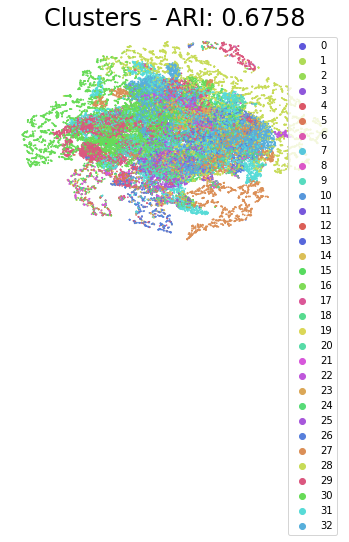

In [ ]:
plotMergedClusters(drop_d1, drop_rcsl1, drop_anno['cell_ontology_class'])

Counter({0: 13700, 3: 10449, 6: 9893, 5: 9265, 4: 8563, 2: 2012, 1: 1774})
Counter({6: 13700, 5: 10449, 4: 9893, 3: 9265, 2: 8563, 1: 2012, 0: 1774})
ari: 0.4016594519377317   mutual: 0.6207461662538959   purity: 0.5034317953140721


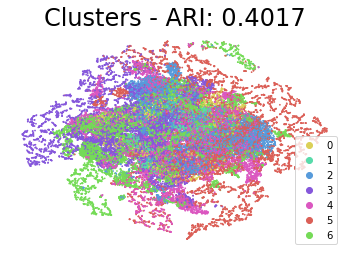

In [ ]:
plotMergedClusters(drop_d2, drop_rcsl2, drop_anno['cell_ontology_class'])

Counter({31: 12546, 23: 8514, 21: 7500, 16: 6830, 20: 4072, 18: 2955, 0: 1963, 22: 1779, 25: 1431, 27: 1219, 28: 1216, 4: 703, 30: 622, 6: 383, 29: 375, 17: 339, 3: 290, 5: 288, 38: 280, 13: 270, 1: 224, 33: 212, 11: 195, 35: 190, 8: 150, 14: 133, 37: 127, 36: 125, 10: 124, 34: 103, 19: 89, 9: 82, 24: 78, 32: 68, 2: 57, 7: 48, 15: 37, 12: 25, 26: 14})
Counter({38: 12546, 37: 8514, 36: 7500, 35: 6830, 34: 4072, 33: 2955, 32: 1963, 31: 1779, 30: 1431, 29: 1219, 28: 1216, 27: 703, 26: 622, 25: 383, 24: 375, 23: 339, 22: 290, 21: 288, 20: 280, 19: 270, 18: 224, 17: 212, 16: 195, 15: 190, 14: 150, 13: 133, 12: 127, 11: 125, 10: 124, 9: 103, 8: 89, 7: 82, 6: 78, 5: 68, 4: 57, 3: 48, 2: 37, 1: 25, 0: 14})
ari: 0.6569372669415079   mutual: 0.7361475053789086   purity: 0.6620490153801926


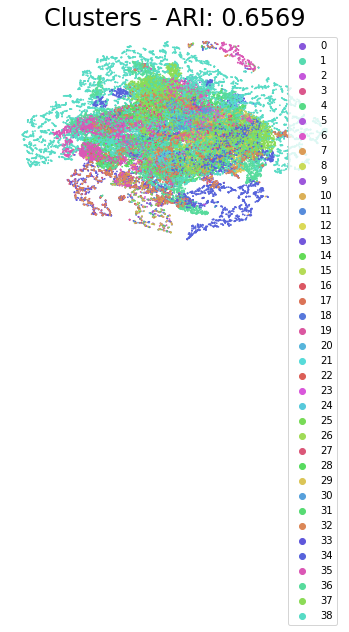

In [ ]:
plotMergedClusters(drop_d3, drop_rcsl3, drop_anno['cell_ontology_class'])

Counter({20: 7516, 22: 5229, 21: 4789, 23: 4136, 18: 3789, 15: 3544, 17: 3192, 16: 2582, 13: 2454, 14: 2334, 12: 2005, 10: 1794, 9: 1786, 8: 1696, 11: 1670, 6: 1216, 4: 1213, 7: 1154, 5: 1142, 0: 822, 19: 557, 3: 430, 1: 354, 2: 252})
Counter({23: 7516, 22: 5229, 21: 4789, 20: 4136, 19: 3789, 18: 3544, 17: 3192, 16: 2582, 15: 2454, 14: 2334, 13: 2005, 12: 1794, 11: 1786, 10: 1696, 9: 1670, 8: 1216, 7: 1213, 6: 1154, 5: 1142, 4: 822, 3: 557, 2: 430, 1: 354, 0: 252})
ari: 0.5672584800348135   mutual: 0.7625457860770786   purity: 0.7179100186862153


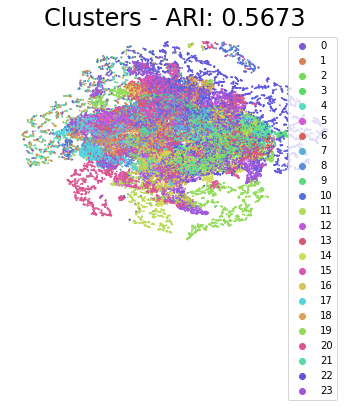

In [ ]:
plotMergedClusters(drop_d4, drop_rcsl4, drop_anno['cell_ontology_class'])

In [ ]:
plotMergedClusters(drop_d5, drop_rcsl5, drop_anno['cell_ontology_class'])

Counter({57: 4593, 56: 4449, 55: 3368, 54: 3226, 53: 2534, 52: 1787, 51: 1634, 50: 1628, 49: 1514, 48: 1373, 47: 1343, 46: 1224, 45: 1213, 44: 1204, 43: 1194, 42: 1163, 41: 1095, 40: 1080, 39: 1061, 38: 1034, 37: 1012, 36: 997, 35: 949, 34: 889, 33: 887, 32: 815, 31: 811, 30: 723, 29: 707, 28: 691, 27: 689, 26: 669, 25: 667, 24: 529, 23: 518, 22: 458, 21: 440, 20: 434, 19: 423, 18: 396, 17: 393, 16: 388, 15: 387, 14: 356, 13: 349, 12: 344, 11: 291, 10: 252, 9: 251, 8: 196, 7: 154, 6: 148, 5: 144, 4: 137, 3: 122, 1: 114, 2: 114, 0: 95})
Counter({57: 4593, 56: 4449, 55: 3368, 54: 3226, 53: 2534, 52: 1787, 51: 1634, 50: 1628, 49: 1514, 48: 1373, 47: 1343, 46: 1224, 45: 1213, 44: 1204, 43: 1194, 42: 1163, 41: 1095, 40: 1080, 39: 1061, 38: 1034, 37: 1012, 36: 997, 35: 949, 34: 889, 33: 887, 32: 815, 31: 811, 30: 723, 29: 707, 28: 691, 27: 689, 26: 669, 25: 667, 24: 529, 23: 518, 22: 458, 21: 440, 20: 434, 19: 423, 18: 396, 17: 393, 16: 388, 15: 387, 14: 356, 13: 349, 12: 344, 11: 291, 10: 2

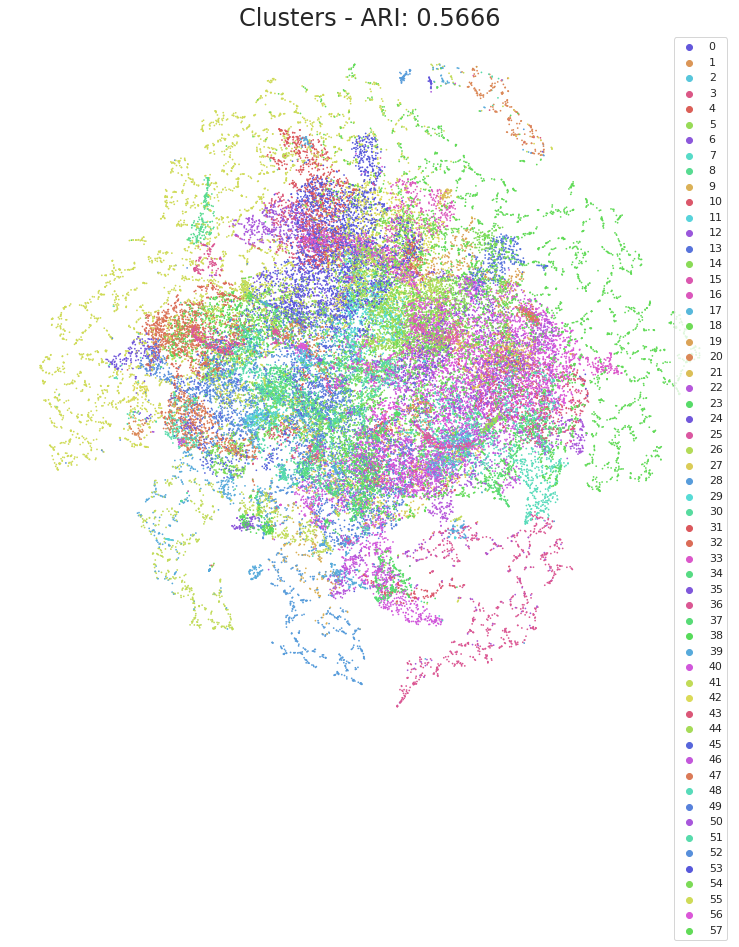

In [ ]:
plotMergedClusters(drop_d6, drop_rcsl6, drop_anno['cell_ontology_class'])

In [ ]:
Counter(drop_anno['cell_ontology_class'].values)

In [ ]:
plt.hist(np.hstack(GAMMA), bins=100)

### PBMC 68K Analysis

In [25]:
from sklearn.utils.sparsefuncs import mean_variance_axis
pbmc = sp.sparse.load_npz('68KPBMC/68KPBMC.npz')
pbmc_hgenes = np.load('./68KPBMC/68kpbmc_hgenes.npy')
pbmc_anno = pd.read_csv('./68KPBMC/pbmc68k_annotations.csv')
total_reads = pbmc.sum(axis=0)
genes = np.array((pbmc != 0).sum(axis=1) > pbmc.shape[1]*1e-3).reshape(1,-1)[0]
pbmc = pbmc.multiply(np.median(total_reads, axis=1)[0,0]/total_reads)
pbmc = pbmc.log1p()
pbmc = pbmc.tocsc()[genes,:].transpose().tocsc()
pbmc_h = pbmc.tocsc()[pbmc_hgenes,:].transpose().tocsc()
pbmc_h = sp.sparse.csc_matrix(Normalizer().fit_transform(pbmc_h.toarray()))

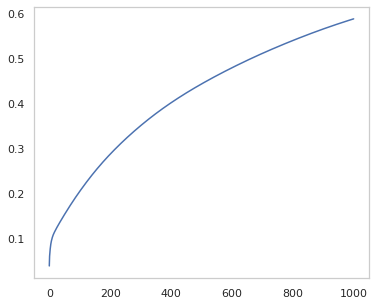

In [31]:
pbmc_genes = pd.read_csv('./68KPBMC/genes.tsv', sep='\t')
pca_pbmc = PCA(n_components=1000)
pca_pbmc.fit(pbmc.toarray())
plt.plot(np.cumsum(pca_pbmc.explained_variance_ratio_))
pbmc_pca = pca_pbmc.transform(pbmc.toarray())


In [32]:
pbmc_d1=DataBag(data=pbmc_pca, umap_transform=False, visualization = pbmc_anno[['TSNE.1', 'TSNE.2']].values)
pbmc_d1.randomSplit(min_size=5000, seed=31413543)

5276


In [ ]:
plt.plot(np.cumsum(tsvd_pbmc.explained_variance_ratio_))

In [ ]:
pbmc_d=DataBag(data=pbmc, umap_transform=False, visualization = pbmc_anno[['TSNE.1', 'TSNE.2']].values)
pbmc_d.randomSplit(min_size=3000, seed=31413543)

In [28]:
pbmc

<68579x11929 sparse matrix of type '<class 'numpy.float64'>'
	with 37204203 stored elements in Compressed Sparse Column format>

In [27]:
!sleep 3600

^C


In [ ]:
findGamma(GAMMA[GAMMA > 0.01], plot=True)

In [ ]:
plotMergedClusters(pbmc_d, pbmc_pack_rcsl, pbmc_anno['celltype'])

In [ ]:
Counter(pbmc_d.data_packs[11].label)

In [54]:
s=time.time()
clusterDataBag(pbmc_d1, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.026624202728271484
centering 0.02822279930114746 

Center by label:  0.017655611038208008
centering 0.01866316795349121 

Center by label:  0.0277407169342041
centering 0.029526948928833008 

Center by label:  0.026825428009033203
centering 0.028305768966674805 

Center by label:  0.026492595672607422
centering 0.026865243911743164 

Center by label:  0.023857593536376953
centering 0.026206016540527344 

Center by label:  0.02945423126220703
centering 0.03095698356628418 

Center by label:  0.03066420555114746
centering 0.03335213661193848 

Center by label:  0.028777360916137695
centering 0.02989029884338379 

Center by label:  0.032541751861572266
centering 0.03368115425109863 

Center by label:  0.02979278564453125
centering 0.03254246711730957 

Center by label:  0.027128934860229492
centering 0.02742791175842285 

Center by label:  0.02838921546936035
centering 0.031091690063476562 

45.112935066223145


In [49]:
pbmc_d2=DataBag(data=pbmc_pca, umap_transform=False, visualization = pbmc_anno[['TSNE.1', 'TSNE.2']].values)
pbmc_d2.randomSplit(min_size=pbmc_pca.shape[0], seed=7)

68579


In [50]:
s=time.time()
clusterDataBag(pbmc_d2, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time()-s)

Center by label:  0.29584455490112305
centering 0.3018214702606201 

133.4344482421875


In [51]:
pbmc1_pca_seurat = clusterMerge(pbmc_d2.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')

In [52]:
plotMergedClusters(pbmc_d2, pbmc1_pca_seurat , pbmc_anno['celltype'], hmap=RESULT, key='pbmc_pca_seurat',   title = 'PBMC68K', file ='./pbmc_pca_seurat',)


Counter({-1: 21838, 12: 17014, 11: 6857, 10: 4547, 9: 4214, 8: 3853, 7: 3772, 6: 2203, 5: 1730, 4: 836, 3: 785, 2: 432, 1: 342, 0: 156})
ari: 0.2978219809545168   ami: 0.5283674078342996   acc: 0.5085257054834086
815
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 

In [101]:
pbmc1_cm_bd_lou = clusterMerge(pbmc_d1.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
pbmc1_cm_sd_lou = clusterMerge(pbmc_d1.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
pbmc1_bm_sd_scc = binaryMerge(pbmc_d1.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
pbmc1_bm_bd_scc = binaryMerge(pbmc_d1.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)


distance calculation:  0.03628182411193848 

merge calculation:  0.08783817291259766
distance calculation:  0.03675699234008789 

merge calculation:  0.09791755676269531
distance calculation:  0.03607916831970215 

merge calculation:  0.09212708473205566
distance calculation:  0.04031014442443848 

merge calculation:  0.08471822738647461
distance calculation:  0.037531137466430664 

merge calculation:  0.09029674530029297
distance calculation:  0.038399457931518555 

merge calculation:  0.09805727005004883
distance calculation:  0.13030695915222168 

merge calculation:  0.18063759803771973
distance calculation:  0.12859296798706055 

merge calculation:  0.1716907024383545
distance calculation:  0.1327202320098877 

merge calculation:  0.18483829498291016
distance calculation:  0.4559633731842041 

merge calculation:  0.34517598152160645
distance calculation:  0.1520097255706787 

merge calculation:  0.24146628379821777
distance calculation:  1.1378250122070312 

merge calculation:  0.8

In [102]:
plotMergedClusters(pbmc_d1, pbmc1_cm_bd_lou, pbmc_anno['celltype'], hmap=RESULT, key='pbmc_pca_seurat_cm_bd_lou',   title = 'PBMC68K', file ='./pbmc_pca_seurat_cm_bd_lou',)
plotMergedClusters(pbmc_d1, pbmc1_cm_sd_lou, pbmc_anno['celltype'], hmap=RESULT, key='pbmc_pca_seurat_cm_sd_lou',   title = 'PBMC68K', file ='./pbmc_pca_seurat_cm_sd_lou',)
plotMergedClusters(pbmc_d1, pbmc1_bm_sd_scc, pbmc_anno['celltype'], hmap=RESULT, key='pbmc_pca_seurat_bm_sd_scc',   title = 'PBMC68K', file ='./pbmc_pca_seurat_bm_sd_scc',)
plotMergedClusters(pbmc_d1, pbmc1_bm_bd_scc, pbmc_anno['celltype'], hmap=RESULT, key='pbmc_pca_seurat_bm_bd_scc',   title = 'PBMC68K', file ='./pbmc_pca_seurat_bm_bd_scc',)

Counter({7: 27112, 6: 11388, 5: 8209, 4: 5885, 3: 5197, 2: 3844, 1: 3619, 0: 2119, -1: 1206})
ari: 0.29617257706000455   ami: 0.4821072526690883   acc: 0.5263236014427144
13
[0 1 2 3 4 5 6 7 8]
ari: 0.28946618721905026   ami: 0.4737977609840273   acc: 0.5236076315282328
[0 1 2 3 4 5 6 7 8]
ari: 0.2855680308023549   ami: 0.47474762685286936   acc: 0.5202859350850078
[ 0  1  2  3  4  5  6  7  8  9 10]
ari: 0.30144023399864056   ami: 0.4841773819840644   acc: 0.5345693317883352
[0 1 2 3 4 5 6 7 8 9]
ari: 0.30423560415421885   ami: 0.4859490403987201   acc: 0.5285024154589372
[ 0  1  2  3  4  5  6  7  8  9 10]
ari: 0.2947243954497378   ami: 0.47250907651880375   acc: 0.5235169898253024
[0 1 2 3 4 5 6 7 8]
ari: 0.30282374133918843   ami: 0.48742974351336543   acc: 0.5251396648044693
[0 1 2 3 4 5 6 7 8]
ari: 0.3073700093669966   ami: 0.4960196161373354   acc: 0.5325648414985591
[0 1 2 3 4 5 6 7]
ari: 0.2981193638571722   ami: 0.48675220740857467   acc: 0.5268236202238518
[0 1 2 3 4 5 6 7 8]


In [47]:
RESULT = {}

In [34]:
pbmc_anno

,barcodes,TSNE.1,TSNE.2,celltype
0,AAACATACACCCAA-1,7.565540,0.441370,CD8+ Cytotoxic T
1,AAACATACCCCTCA-1,2.552626,-25.786672,CD8+/CD45RA+ Naive Cytotoxic
2,AAACATACCGGAGA-1,-5.771831,11.830846,CD4+/CD45RO+ Memory
3,AAACATACTAACCG-1,1.762556,25.979346,CD19+ B
4,AAACATACTCTTCA-1,-16.793856,-16.589970,CD4+/CD25 T Reg
...,...,...,...,...
68574,TTTGCATGAGCCTA-8,1.430476,-23.815174,CD8+ Cytotoxic T
68575,TTTGCATGCTAGCA-8,3.120762,-19.108131,CD8+/CD45RA+ Naive Cytotoxic
68576,TTTGCATGCTGCAA-8,13.526124,-1.559099,CD8+ Cytotoxic T
68577,TTTGCATGGCTCCT-8,11.646083,-3.386890,CD8+ Cytotoxic T


In [ ]:
GAMMA =[]
pbmc_pack_rcsl = binaryMerge(pbmc_d.data_packs, method='scc', gamma=0.32, dist_method='bidirectionDist')

In [92]:
pd.DataFrame(RESULT).to_csv('./pbmc.seurat.csv')

### MCA 270K Analysis

In [58]:
import tables
import scipy as sp
def readH5(file):
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    shape=getattr(mat_group, 'shape').read()
    genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
    barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
    indptr=getattr(mat_group, 'indptr').read()
    data = getattr(mat_group, 'data').read()
    indices = getattr(mat_group, 'indices').read()
    matrix = sp.sparse.csc_matrix((data, indices, indptr), shape=shape)
    return matrix, genes, barcodes


mca_mat, mca_g, mca_b= readH5('./MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.h5')
cells = np.array((mca_mat != 0).sum(axis=0) > 500).reshape(1,-1)[0]
mca_mat = mca_mat[:, cells]
total_reads = mca_mat.sum(axis=0)
mca_mat = mca_mat.multiply(np.median(total_reads, axis=1)[0,0]/total_reads)
mca_mat = mca_mat.log1p().tocsc()
genes = np.array((mca_mat != 0).sum(axis=1) > mca_mat.shape[1]*1e-3).reshape(1,-1)[0]
mca_hgenes = np.load('./MouseCellAtlas270K_rmbatch/HighVariableGeneIndex_MCA270K.npy')
mca_h = mca_mat[mca_hgenes,:].transpose().tocsc()
mca = mca_mat[genes,:].transpose().tocsc()
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')
#mca_h = mca_h[np.where(mca_h.sum(axis=1) > 0)[0],:]
#mca_anno = mca_anno.iloc[np.where(mca_h.sum(axis=1) > 0)[0]]
mca_test = mca[110000:140000,:]
mca_umap = np.load('./MouseCellAtlas270K_rmbatch/mca_270k.umap.npz')['arr_0']
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')

In [ ]:
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')

In [60]:
mca_mat

<39147x149776 sparse matrix of type '<class 'numpy.float64'>'
	with 125374400 stored elements in Compressed Sparse Column format>

In [ ]:
len(Counter([s.split('_')[0] for s in mca_b]))

42

In [ ]:
mca_test = mca[110000:140000,:]
mca_umap = np.load('./MouseCellAtlas270K_rmbatch/mca_270k.umap.npz')['arr_0']
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')
mca_anno = mca_anno.iloc[cells].iloc[110000:140000]

In [66]:
mca_umap = np.load('./MouseCellAtlas270K_rmbatch/mca_270k.umap.npz')['arr_0']

In [ ]:
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')

In [61]:
mca_pca = np.load('./MouseCellAtlas270K_rmbatch/mca_pca.npz')['arr_0']

In [64]:
mca_anno

,Cell.name,ClusterID,Tissue,Batch,Cell.Barcode,Annotation
0,FetalStomach_1.TCAAAGGCCTAGTGAAGC,Fetal_Stomache_8,Fetal_Stomache,FetalStomach_1,TCAAAGGCCTAGTGAAGC,Acinar cell_Spp1 high(Fetal_Stomache)
1,SmallIntestine_3.AGGGTCTTCCGCTCTACC,Small-Intestine_7,Small-Intestine,SmallIntestine_3,AGGGTCTTCCGCTCTACC,Epithelium of small intestinal villi_Fabp6 hig...
2,MesenchymalStemCellsPrimary_1.ACAATATAAGGGAACGCC,Bone_Marrow_Mesenchyme_7,Bone_Marrow_Mesenchyme,MesenchymalStemCellsPrimary_1,ACAATATAAGGGAACGCC,B cell(Bone_Marrow_Mesenchyme)
3,FetalFemaleGonad_1.CAAAGTACGAGCAAAACG,Female_Fetal_Gonad_1,Female_Fetal_Gonad,FetalFemaleGonad_1,CAAAGTACGAGCAAAACG,Primordial germ cell(Female_Fetal_Gonad)
4,EmbryonicStemCells_1.ACACCCATCAACCTCCAT,Embryonic-Stem-Cell_1,Embryonic-Stem-Cell,EmbryonicStemCells_1,ACACCCATCAACCTCCAT,ES_Actb_high(Embryonic-Stem-Cell)
...,...,...,...,...,...,...
270806,Kidney_1.CGCTTGCGTGGCCATCCC,Fetal_Kidney_5,Fetal_Kidney,Fetal_Kidney_1,CGCTTGCGTGGCCATCCC,Stromal cell_Mgp high(Fetal_Kidney)
270807,PeripheralBlood_2.ACACCCATTCCAAGATGG,Peripheral_Blood_4,Peripheral_Blood,PeripheralBlood_2,ACACCCATTCCAAGATGG,Neutrophil_Retnlg high(Peripheral_Blood)
270808,NeonatalSkin_1.CATCCCAGTCGTTGGATG,Neonatal-Skin_8,Neonatal-Skin,NeonatalSkin_1,CATCCCAGTCGTTGGATG,Muscle cell_Lrrc15 high(Neonatal-Skin)
270809,BoneMarrowcKit_2.TTCCGCCCATCTCCATCT,Bone-Marrow_c-kit_7,Bone-Marrow_c-kit,BoneMarrowcKit_2,TTCCGCCCATCTCCATCT,Monocyte progenitor cell_Ctsg high(Bone-Marrow...


In [68]:
mca_umap.shape

(270811, 2)

In [78]:
mca_anno = mca_anno.iloc[cells]

In [72]:
mca_pca.shape

(270811, 200)

In [ ]:
mca_d=DataBag(data=mca, umap_transform=True)

In [ ]:
mca_d.randomSplit(min_size=3000, seed=13)

In [ ]:
tsvd_mca = TruncatedSVD(n_components=200)
tsvd_mca.fit(mca_mat.transpose())
plt.plot(np.cumsum(tsvd_mca.explained_variance_ratio_))

In [ ]:
mca_pca = tsvd_mca.transform(mca_mat.transpose())

In [86]:
mca_d1=DataBag(data=mca_pca[cells,:], umap_transform=False, visualization = mca_umap[cells,:])
mca_d1.randomSplit(min_size=14000, seed=1451771)

14978


In [ ]:
mca_d2=DataBag(data=mca_pca[cells,:], umap_transform=False, visualization = mca_umap[cells,:])
mca_d2.randomSplit(min_size=mca_pca.shape[0], seed=1451771)

In [103]:
mca1_cm_bd_lou = clusterMerge(mca_d1.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')
mca1_cm_sd_lou = clusterMerge(mca_d1.data_packs, method='sampleDist', gamma=0.8, merge = 'louvain')
mca1_bm_sd_scc = binaryMerge(mca_d1.data_packs, method='scc',  dist_method = 'sampleDist',gamma=0.8)
mca1_bm_bd_scc = binaryMerge(mca_d1.data_packs, method='scc',  dist_method = 'BDDist', gamma=0.3)

distance calculation:  0.10854816436767578 

merge calculation:  0.22940492630004883
distance calculation:  0.09507107734680176 

merge calculation:  0.20522403717041016
distance calculation:  0.11010241508483887 

merge calculation:  0.20747756958007812
distance calculation:  0.10011577606201172 

merge calculation:  0.20354247093200684
distance calculation:  0.10645842552185059 

merge calculation:  0.20690631866455078
distance calculation:  0.41331052780151367 

merge calculation:  0.5019693374633789
distance calculation:  0.3891286849975586 

merge calculation:  0.4665989875793457
distance calculation:  1.33870267868042 

merge calculation:  1.521683931350708
distance calculation:  1.6676790714263916 

merge calculation:  2.337723970413208
distance calculation:  0.2099771499633789 

merge calculation:  0.22303366661071777
distance calculation:  0.19701242446899414 

merge calculation:  0.21633410453796387
distance calculation:  0.2031259536743164 

merge calculation:  0.21854591369

In [83]:
mca2_seurat = clusterMerge(mca_d2.data_packs, method='BDDist', gamma=0.8, merge = 'louvain')

In [108]:
len(Counter(mca_anno['Annotation']))

762

In [106]:
plotMergedClusters(mca_d2, mca2_seurat, mca_anno['Annotation'], hmap=RESULT, key='mca_pca_seurat',   title = 'MCA140K', file ='./mca_pca_seurat',)


Counter({64: 11074, 63: 8780, 62: 8002, 61: 7777, 60: 7344, 59: 7136, 58: 6780, 57: 6733, 56: 5307, 55: 4952, 54: 4424, 53: 4395, 52: 4143, 51: 3867, 50: 3582, 49: 3312, 48: 3120, 47: 2692, 46: 2612, 45: 2452, 44: 2441, 43: 2366, 42: 1955, 41: 1801, 40: 1760, 39: 1664, 38: 1607, 37: 1551, 36: 1507, 35: 1483, 34: 1462, 33: 1341, 32: 1330, 31: 1323, 30: 1309, 29: 1217, 28: 1198, 27: 1100, 26: 1076, 25: 996, 24: 983, 23: 867, 22: 855, 21: 764, 20: 762, 19: 734, 18: 724, 17: 576, 16: 573, 15: 547, 14: 470, 13: 445, 12: 392, 11: 332, 10: 294, 9: 273, 8: 231, 7: 189, 6: 173, 5: 129, 4: 124, 2: 109, 3: 109, 1: 98, 0: 43, -1: 9})
ari: 0.3722226038186529   ami: 0.7071526268824996   acc: 0.3647666041250743
67
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
ari: 0.37222206735235314   ami: 0.707141184759378   acc: 0.36475866811775154


In [107]:
plotMergedClusters(mca_d1, mca1_cm_bd_lou, mca_anno['Annotation'], hmap=RESULT, key='mca_pca_seurat_cm_bd_lou',   title = 'PBMC68K', file ='./mca_pca_seurat_cm_bd_lou',)
plotMergedClusters(mca_d1, mca1_cm_sd_lou, mca_anno['Annotation'], hmap=RESULT, key='mca_pca_seurat_cm_sd_lou',   title = 'PBMC68K', file ='./mca_pca_seurat_cm_sd_lou',)
plotMergedClusters(mca_d1, mca1_bm_sd_scc, mca_anno['Annotation'], hmap=RESULT, key='mca_pca_seurat_bm_sd_scc',   title = 'PBMC68K', file ='./mca_pca_seurat_bm_sd_scc',)
plotMergedClusters(mca_d1, mca1_bm_bd_scc, mca_anno['Annotation'], hmap=RESULT, key='mca_pca_seurat_bm_bd_scc',   title = 'PBMC68K', file ='./mca_pca_seurat_bm_bd_scc',)

Counter({21: 20314, 20: 18543, 19: 17386, 18: 12509, 17: 12430, 16: 10337, 15: 8070, 14: 7757, 13: 7297, 12: 7016, 11: 4485, 10: 4450, 9: 3713, 8: 3009, 7: 2950, 6: 2426, 5: 1827, 4: 1509, 3: 1441, 2: 986, 1: 843, 0: 478})
ari: 0.2026500830207555   ami: 0.5922935178727617   acc: 0.2671188975536802
34
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
ari: 0.2834075469453998   ami: 0.6243367216747653   acc: 0.30751769261583656
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
ari: 0.2575792176351685   ami: 0.615721204237559   acc: 0.29496595006008813
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
ari: 0.2486548574509043   ami: 0.6168341346451515   acc: 0.296034183469088
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
ari: 0.2647240374366475   ami: 0.6110029072176701   acc: 0.28922419548671385
[ 0  1  2  3  4

In [91]:
RESULT

{'mca_pca_seurat': {'acc': 0.5430234964978934,
  'ami': 0.7048794096663679,
  'ari': 0.5223889508277335},
 'mca_pca_seurat_bm_bd_scc': {'acc': 0.5621127550475377,
  'ami': 0.6524857604151787,
  'ari': 0.5144541451650736},
 'mca_pca_seurat_bm_sd_scc': {'acc': 0.5571720435850871,
  'ami': 0.6456836086680454,
  'ari': 0.5239211994133356},
 'mca_pca_seurat_cm_bd_lou': {'acc': 0.52581855570986,
  'ami': 0.638431289821809,
  'ari': 0.4163146101295073},
 'mca_pca_seurat_cm_sd_lou': {'acc': 0.5501816045294307,
  'ami': 0.648444560043999,
  'ari': 0.4801362938936047},
 'pbmc_pca_seurat': {'acc': 0.5085257054834086,
  'ami': 0.5283674078342996,
  'ari': 0.2978219809545168},
 'pbmc_pca_seurat_bm_bd_scc': {'acc': 0.5226432738121743,
  'ami': 0.47668332225007454,
  'ari': 0.29629469138727865},
 'pbmc_pca_seurat_bm_sd_scc': {'acc': 0.409426740252804,
  'ami': 0.38932380969621894,
  'ari': 0.25343826222340754},
 'pbmc_pca_seurat_cm_bd_lou': {'acc': 0.5263236014427144,
  'ami': 0.4821072526690883,
  '

In [ ]:
mca_d2=DataBag(data=mca_pca, umap_transform=False, visualization = mca_umap[cells,:])
mca_d2.randomSplit(min_size=5000, seed=1451771)

In [ ]:
mca_d3=DataBag(data=mca_pca, umap_transform=False, visualization = mca_umap[cells,:])
mca_d3.randomSplit(min_size=3000, seed=1451771)
mca_d4=DataBag(data=mca_pca, umap_transform=False, visualization = mca_umap[cells,:])
mca_d4.randomSplit(min_size=10000, seed=1451771)

In [ ]:
mca_d3=DataBag(data=mca_pca, umap_transform=False, visualization = mca_umap[cells,:])
mca_d3.randomSplit(min_size=4000, seed=1451771)

In [ ]:
mca_d5=DataBag(data=mca_pca, umap_transform=False, visualization = mca_umap[cells,:])
mca_d5.randomSplit(min_size=mca_pca.shape[0], seed=1451771)

In [82]:
s = time.time()
clusterDataBag(mca_d2, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time() - s)

Center by label:  0.13863182067871094
centering 0.14032626152038574 

297.90407490730286


In [87]:
s = time.time()
clusterDataBag(mca_d1, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time() - s)

Center by label:  0.012474775314331055
centering 0.014064550399780273 

Center by label:  0.013089895248413086
centering 0.014091253280639648 

Center by label:  0.012315750122070312
centering 0.013353347778320312 

Center by label:  0.012231826782226562
centering 0.013254404067993164 

Center by label:  0.01180410385131836
centering 0.01324009895324707 

Center by label:  0.014771223068237305
centering 0.015788555145263672 

Center by label:  0.012288093566894531
centering 0.013320446014404297 

Center by label:  0.012781143188476562
centering 0.014417171478271484 

Center by label:  0.012250423431396484
centering 0.013318300247192383 

Center by label:  0.013334989547729492
centering 0.01488184928894043 

79.94981241226196


In [ ]:
import time
s = time.time()
clusterDataBag(mca_d3, BDSMClust, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time() - s)

eigen:  4.543360948562622
dist:  0.2042407989501953
update:  3.4632630348205566
eigen:  4.555302619934082
loop:  9.096610307693481


dist:  0.23107576370239258
update:  1.3092987537384033
eigen:  4.558291673660278
loop:  6.992327690124512


dist:  0.18340849876403809
update:  1.2698485851287842
eigen:  4.514655113220215
loop:  6.805525302886963


dist:  0.23098063468933105
update:  1.1970088481903076
eigen:  4.595499038696289
loop:  6.9169135093688965


dist:  0.2370154857635498
update:  1.1072962284088135
eigen:  4.466716527938843
loop:  6.6504411697387695


dist:  0.18406963348388672
update:  0.8632657527923584
eigen:  4.526082992553711
loop:  6.460850238800049


dist:  0.20238924026489258
update:  0.7590916156768799
eigen:  4.454387664794922
loop:  6.245678663253784


dist:  0.2059459686279297
update:  0.6377570629119873
eigen:  4.579941511154175
loop:  6.316794157028198


dist:  0.19644999504089355
update:  0.6185429096221924
eigen:  4.468629837036133
loop:  6.117287635803223


dis

In [ ]:
import time
s = time.time()
clusterDataBag(mca_d4, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time() - s)

Center by label:  0.010911226272583008
centering 0.012222528457641602 

Center by label:  0.01118922233581543
centering 0.012238025665283203 

Center by label:  0.011135101318359375
centering 0.011419057846069336 

Center by label:  0.010347843170166016
centering 0.011875629425048828 

Center by label:  0.010016679763793945
centering 0.011222600936889648 

Center by label:  0.010837316513061523
centering 0.011858701705932617 

Center by label:  0.009960651397705078
centering 0.010929346084594727 

Center by label:  0.010196208953857422
centering 0.01150202751159668 

Center by label:  0.009815692901611328
centering 0.010786056518554688 

Center by label:  0.009926795959472656
centering 0.01120305061340332 

Center by label:  0.010364294052124023
centering 0.011624336242675781 

Center by label:  0.010068178176879883
centering 0.010303735733032227 

Center by label:  0.010062694549560547
centering 0.011017084121704102 

Center by label:  0.010112285614013672
centering 0.0117056369781494

In [ ]:
import time
s = time.time()
clusterDataBag(mca_d5, findLouvain, precomputed=False, metric='SCP', kernel_sim = True, kernel=SCP2sim)
print(time.time() - s)

Center by label:  0.20749258995056152
centering 0.20876550674438477 

297.5387887954712


In [ ]:
GAMMA =[]
mca_pack_rcsl = binaryMerge(mca_d.data_packs, method='scc', gamma=0.8, dist_method='sampleDist')


distance calculation:  1.3539674282073975 

merge calculation:  0.6603076457977295
distance calculation:  1.3035635948181152 

merge calculation:  0.6561810970306396
distance calculation:  1.2926092147827148 

merge calculation:  0.6471922397613525
distance calculation:  1.2727324962615967 

merge calculation:  0.6486644744873047
distance calculation:  1.2908458709716797 

merge calculation:  0.6527235507965088
distance calculation:  1.276031732559204 

merge calculation:  0.6503064632415771
distance calculation:  1.2763712406158447 

merge calculation:  0.6575345993041992
distance calculation:  1.2791402339935303 

merge calculation:  0.6484684944152832
distance calculation:  1.2771501541137695 

merge calculation:  0.6450948715209961
distance calculation:  1.2668235301971436 

merge calculation:  0.6578145027160645
distance calculation:  1.2643325328826904 

merge calculation:  0.6575021743774414
distance calculation:  1.2764959335327148 

merge calculation:  0.6494624614715576
dista

In [ ]:
GAMMA =[]
mca_pack_louvain = binaryMerge(mca_d2.data_packs, method='scc', gamma=0.3, dist_method='BDDist')

distance calculation:  2.3998539447784424 

merge calculation:  0.62235426902771
distance calculation:  2.2431583404541016 

merge calculation:  0.6250996589660645
distance calculation:  2.2364230155944824 

merge calculation:  0.6166625022888184
distance calculation:  2.241727828979492 

merge calculation:  0.6230051517486572
distance calculation:  2.2105157375335693 

merge calculation:  0.6224687099456787
distance calculation:  2.260101795196533 

merge calculation:  0.6192553043365479
distance calculation:  2.2050862312316895 

merge calculation:  0.6291420459747314
distance calculation:  2.2454211711883545 

merge calculation:  0.6216452121734619
distance calculation:  2.2299559116363525 

merge calculation:  0.6262249946594238
distance calculation:  2.2314391136169434 

merge calculation:  0.6269285678863525
distance calculation:  2.202439308166504 

merge calculation:  0.623166561126709
distance calculation:  2.2223384380340576 

merge calculation:  0.628216028213501
distance ca

In [ ]:
GAMMA =[]
mca_pack_louvain4 = binaryMerge(mca_d4.data_packs, method='scc', gamma=0.7, dist_method='sampleDist')

distance calculation:  0.06690239906311035 

merge calculation:  0.1419239044189453
distance calculation:  0.05428147315979004 

merge calculation:  0.14133191108703613
distance calculation:  0.05672597885131836 

merge calculation:  0.13612794876098633
distance calculation:  0.05746960639953613 

merge calculation:  0.13845252990722656
distance calculation:  0.0512242317199707 

merge calculation:  0.1381239891052246
distance calculation:  0.05103039741516113 

merge calculation:  0.14159393310546875
distance calculation:  0.05191802978515625 

merge calculation:  0.14023041725158691
distance calculation:  0.09784936904907227 

merge calculation:  0.2329111099243164
distance calculation:  0.09308910369873047 

merge calculation:  0.21918153762817383
distance calculation:  0.09605884552001953 

merge calculation:  0.22728538513183594
distance calculation:  0.06752943992614746 

merge calculation:  0.18011188507080078
distance calculation:  0.2754170894622803 

merge calculation:  0.384

In [ ]:
mca_d4.data_packs

In [ ]:
GAMMA =[]
mca_pack_louvain5 = binaryMerge(mca_d5.data_packs, method='scc', gamma=0.3, dist_method='BDDist')

In [ ]:
plotMergedClusters(mca_d, mca_pack_rcsl, mca_anno['Annotation'], title='MCA140k Tissue Cluster (BM-Seurat)', file='mca140k.seurat')

In [ ]:
plotMergedClusters(mca_d2, mca_pack_louvain, mca_anno['Tissue'], title='MCA140k Tissue Cluster (BM-Seurat)', file='mca140k.seurat')

Counter({27: 21340, 17: 12499, 23: 10362, 26: 10327, 25: 9347, 24: 9327, 4: 8949, 19: 8099, 22: 8069, 21: 7755, 18: 6948, 16: 6320, 15: 4431, 6: 3889, 10: 3113, 14: 3032, 13: 3004, 12: 2346, 11: 1986, 8: 1505, 1: 1466, 9: 1337, 2: 1073, 7: 930, 3: 712, 20: 692, 28: 487, 5: 345, 0: 86})
Counter({28: 21340, 27: 12499, 26: 10362, 25: 10327, 24: 9347, 23: 9327, 22: 8949, 21: 8099, 20: 8069, 19: 7755, 18: 6948, 17: 6320, 16: 4431, 15: 3889, 14: 3113, 13: 3032, 12: 3004, 11: 2346, 10: 1986, 9: 1505, 8: 1466, 7: 1337, 6: 1073, 5: 930, 4: 712, 3: 692, 2: 487, 1: 345, 0: 86})
ari: 0.4987889956445033   mutual: 0.6353905771145286   purity: 0.5825699711569277


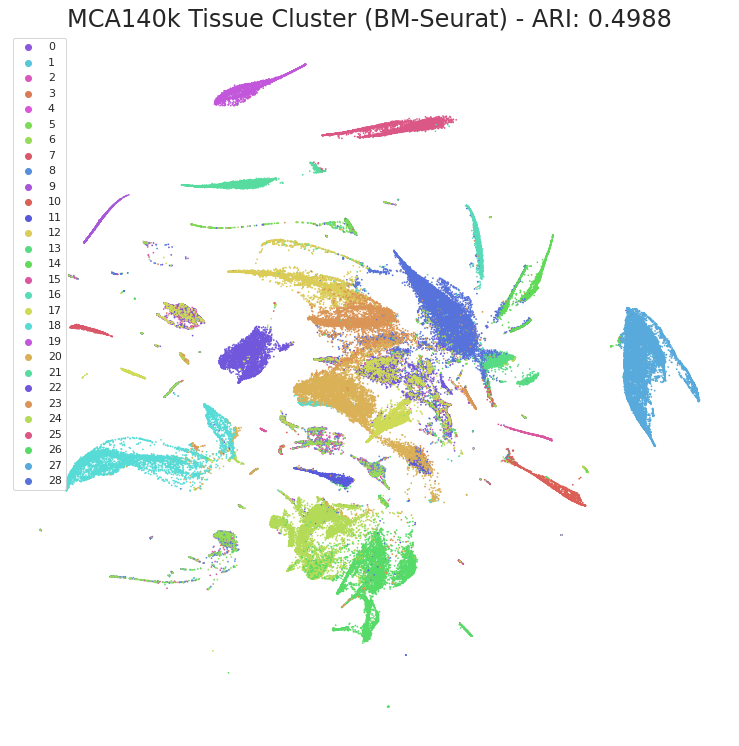

In [ ]:
plotMergedClusters(mca_d4, mca_pack_louvain4, mca_anno['Tissue'], title='MCA140k Tissue Cluster (BM-Seurat)', file='mca140k.seurat')

Counter({68: 10794, 67: 8824, 66: 7756, 65: 7296, 64: 7219, 63: 6771, 62: 6712, 61: 6654, 60: 4610, 59: 4420, 58: 4244, 57: 4148, 56: 3824, 55: 3533, 54: 3428, 53: 3310, 52: 3075, 51: 2982, 50: 2693, 49: 2600, 48: 2565, 47: 2477, 46: 2406, 45: 1923, 44: 1793, 43: 1676, 42: 1675, 41: 1611, 40: 1549, 39: 1522, 38: 1503, 37: 1492, 35: 1346, 36: 1346, 34: 1328, 33: 1315, 32: 1226, 31: 1225, 30: 1138, 29: 1102, 28: 1050, 27: 1044, 26: 878, 25: 823, 24: 818, 23: 789, 22: 784, 21: 750, 20: 584, 19: 544, 18: 486, 17: 478, 15: 445, 16: 445, 14: 389, 13: 329, 12: 278, 11: 246, 10: 220, 9: 198, 8: 171, 7: 134, 6: 131, 5: 127, 3: 110, 4: 110, 2: 106, 1: 92, 0: 85, -1: 21})
Counter({68: 10794, 67: 8824, 66: 7756, 65: 7296, 64: 7219, 63: 6771, 62: 6712, 61: 6654, 60: 4610, 59: 4420, 58: 4244, 57: 4148, 56: 3824, 55: 3533, 54: 3428, 53: 3310, 52: 3075, 51: 2982, 50: 2693, 49: 2600, 48: 2565, 47: 2477, 46: 2406, 45: 1923, 44: 1793, 43: 1676, 42: 1675, 41: 1611, 40: 1549, 39: 1522, 38: 1503, 37: 1492, 

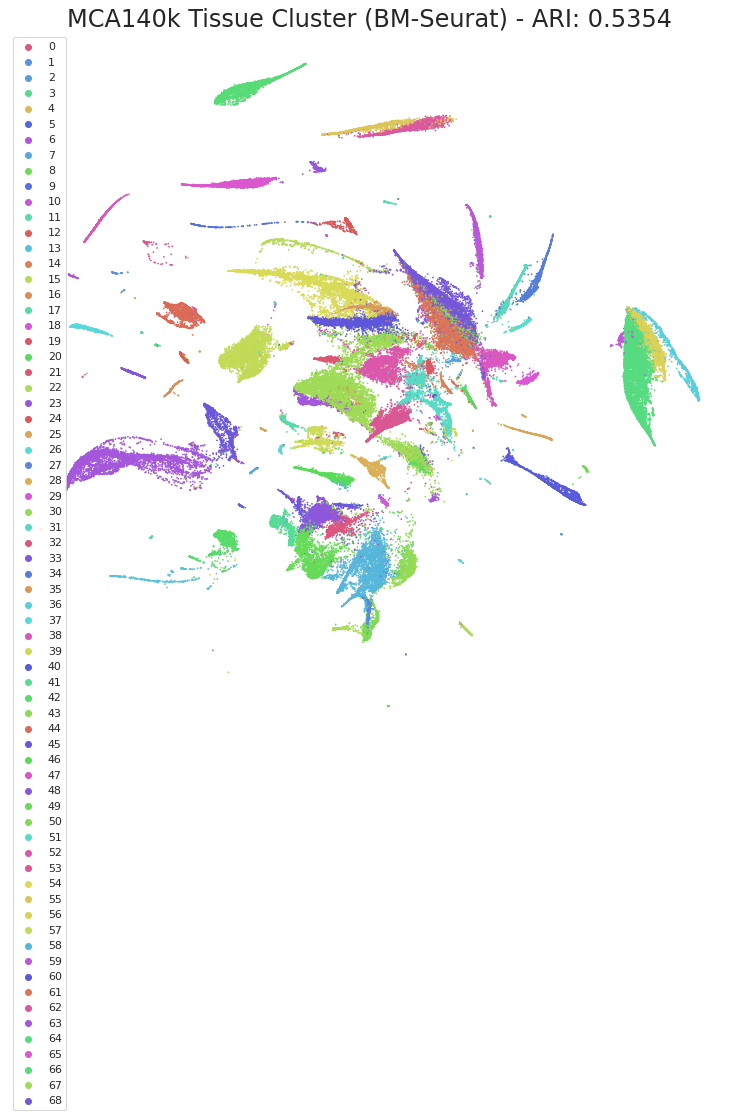

In [ ]:
plotMergedClusters(mca_d5, mca_pack_louvain5, mca_anno['Tissue'], title='MCA140k Tissue Cluster (BM-Seurat)', file='mca140k.seurat')

In [ ]:
plt.hist(np.hstack(GAMMA), bins=100, log=True)

In [ ]:
plotMergedClusters(mca_d, mca_pack_rcsl, mca_anno['Tissue'], title='MCA140k Tissue Cluster (BM-RCSL)', file='mca140k.rcsl')

In [ ]:
!cp *png gdrive/My\ Drive/

In [ ]:
GAMMA=[]
for i in np.arange(0.45,0.6, 0.01):
    mca_pack = binaryMerge(mca_d_pca.data_packs, method='sampleWise', gamma=i, dist_method='bidirectionDist')
#print(Counter(d_mca_pack[0].label))
    inds = mca_pack[0].indices[mca_pack[0].label != -1]
    labels = mca_pack[0].label[mca_pack[0].label != -1]
    print('\ni:'+str(i))
    print(adjusted_rand_score(pd.Categorical(mca_anno['Tissue']).codes[inds], labels))

In [ ]:
Counter(pd.Categorical(mca_anno['Tissue']).codes)

In [ ]:
print(Counter(mca_pack[0].label))
inds = mca_pack[0].indices[mca_pack[0].label != -1]
labels = mca_pack[0].label[mca_pack[0].label != -1]
print(adjusted_rand_score(pd.Categorical(mca_anno['Tissue']).codes[inds], labels))
d_umap = mca_d.data_vis[inds,:]
#d_umap = mca_d.data_vis[inds,:]
palette = sns.color_palette("hls", len(np.unique(labels))) if np.any(labels!= None) else None
sns.scatterplot(x=d_umap[:,0], y=d_umap[:,1], hue=labels, s=3, palette = palette, edgecolor="none")
plt.title('Spectral Cluster (30) SCC merge theta: 0.35')
plt.savefig('./mca270_sclust_60_scc_0.35.tsne.png', dpi=300)


In [ ]:
print(Counter(mca_pack[0].label))
inds = mca_pack[0].indices[mca_pack[0].label != -1]
labels = mca_pack[0].label[mca_pack[0].label != -1]
print(adjusted_rand_score(pd.Categorical(mca_anno['Tissue']).codes[inds], labels))
d_umap = mca_d.data_vis[inds,:]
#d_umap = mca_d.data_vis[inds,:]
palette = sns.color_palette("hls", len(np.unique(labels))) if np.any(labels!= None) else None
sns.scatterplot(x=d_umap[:,0], y=d_umap[:,1], hue=labels, s=3, palette = palette, edgecolor="none")
plt.title('Spectral Cluster (30) SCC merge theta: 0.35')
plt.savefig('./mca270_sclust_60_scc_0.35.tsne.png', dpi=300)


In [ ]:
plotMergedClusters(mca_d, mca_pack_rcsl, mca_anno['Tissue'])

In [ ]:
plt.hist(GAMMA, bins=100, log=True)

In [ ]:
a=[i[1] for i in Counter(mca_pack[0].label).items()]

In [ ]:
new_labels = sort_labels(mca_pack[0].label)
Counter(new_labels)

In [ ]:
new_labels = sort_labels(mca_pack[0].label)
inds = mca_pack[0].indices[new_labels > 66]
labels = new_labels[new_labels > 66] - 66
ari = adjusted_rand_score(pd.Categorical(mca_anno['Tissue']).codes[inds], labels)
print(ari)
d_umap = mca_d_pca.data_vis[inds,:]
#d_umap = pbmc_hg.data_vis[inds,:]
palette = sns.color_palette("hls", len(np.unique(labels))) if np.any(labels!= None) else None
sns.scatterplot(x=d_umap[:,0], y=d_umap[:,1], hue=labels, s=3, palette = palette, edgecolor="none")
plt.title('Spectral Cluster (30) SCC merge theta: 0.35 -- ARI:'+str(round(ari ,4)))
plt.savefig('./mca270_sclust_60_scc_0.35.tsne.png', dpi=300)

In [ ]:
s = time.time()
mca_pack_scc = binaryMerge(mca_d.data_packs, method='scc', gamma=0.15, dist_method='bidirectionDist')
print(time.time() - s)


In [ ]:
print(adjusted_rand_score(pd.Categorical(mca_anno['Tissue']).codes, labels))

0.3826844655794009


In [ ]:
clusterDataBag(d_pbmc, agg, precomputed=True, metric='SCP')

In [ ]:
clusterDataBag(pbmc, sclust, precomputed=True, metric='SCP', kernel_sim = True, kernel = SCP2sim)

## Neuron 1300K

In [ ]:
import tables
import scipy as sp
def readH5(file):
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    shape=getattr(mat_group, 'shape').read()
    genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
    barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
    indptr=getattr(mat_group, 'indptr').read()
    data = getattr(mat_group, 'data').read()
    indices = getattr(mat_group, 'indices').read()
    matrix = sp.sparse.csc_matrix((data, indices, indptr), shape=shape)
    return matrix, genes, barcodes


mnd_mat, mnd_g, mnd_b= readH5('./Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5') 
cells = np.array((mca_mat != 0).sum(axis=0) > 500).reshape(1,-1)[0]
mca_mat = mca_mat[:, cells]
total_reads = mca_mat.sum(axis=0)
mca_mat = mca_mat.multiply(np.median(total_reads, axis=1)[0,0]/total_reads)
mca_mat = mca_mat.log1p().tocsc()
genes = np.array((mca_mat != 0).sum(axis=1) > mca_mat.shape[1]*1e-3).reshape(1,-1)[0]
mca_hgenes = np.load('./MouseCellAtlas270K_rmbatch/HighVariableGeneIndex_MCA270K.npy')
mca_h = mca_mat[mca_hgenes,:].transpose().tocsc()
mca = mca_mat[genes,:].transpose().tocsc()
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')
#mca_h = mca_h[np.where(mca_h.sum(axis=1) > 0)[0],:]
#mca_anno = mca_anno.iloc[np.where(mca_h.sum(axis=1) > 0)[0]]
mca_test = mca[110000:140000,:]
mca_umap = np.load('./MouseCellAtlas270K_rmbatch/mca_270k.umap.npz')['arr_0']
mca_anno = pd.read_csv('MouseCellAtlas270K_rmbatch/MouseCellAtlas270K_rmbatch.csv')
mca_anno = mca_anno.iloc[cells].iloc[110000:140000]

In [ ]:
import tables
import scipy as sp
def readH5(file):
    f=tables.open_file(file, 'r')
    node = str(f.list_nodes('/')[0]).split('/')[1].split(' ')[0]
    mat_group = f.get_node(f.root, node)
    shape=getattr(mat_group, 'shape').read()
    genes = [g.decode() for g in getattr(mat_group, 'genes').read()]
    barcodes = [g.decode() for g in getattr(mat_group, 'barcodes').read()]
    #indptr=getattr(mat_group, 'indptr').read()
    #data = getattr(mat_group, 'data').read()
    #indices = getattr(mat_group, 'indices').read()
    #matrix = sp.sparse.csc_matrix((data, indices, indptr), shape=shape)
    print(shape)
    return genes, barcodes

mnd_g, mnd_b= readH5('./Neuron_1300K/1M_neurons_filtered_gene_bc_matrices_h5.h5') 

[  27998 1306127]


In [ ]:
%timeit randomReadCSC(indices, indptr0, fp, a)

1 loop, best of 5: 3.18 s per loop


array([21494, 21491, 21479, ...,  5073,  5065,  5060], dtype=int16)

In [ ]:
import time

In [ ]:
np.concatenate(np.array([np.array([1,2,3]), np.array([1,2,35,5])]))

In [ ]:
%timeit d = ToCSC(e.indices, e.indptr, e.data, a)

10 loops, best of 5: 103 ms per loop


In [ ]:
%timeit d = dset['data'][0:197980827]

1 loop, best of 5: 2.54 s per loop


In [ ]:
%timeit d = e[:,a]

10 loops, best of 5: 54 ms per loop


In [ ]:
random.sample(g['matrix'],1000)

In [ ]:
a= np.arange(0,1050000)
np.random.shuffle(a)
a = np.sort(a[:20000])

In [ ]:
g = h5py.File('test.h5', 'w')

In [ ]:
g.create_dataset('matrix',data=sparse.csc_matrix((dset['data'][:dset['indptr'][50000]], dset['indices'][:dset['indptr'][50000]], dset['indptr'][:50001])).toarray())

<HDF5 dataset "matrix": shape (27998, 50000), type "<i4">

In [ ]:
sparse.csc_matrix((dset['data'][:dset['indptr'][1000]], dset['indices'][:dset['indptr'][1000]], dset['indptr'][:1001]))

<27998x1000 sparse matrix of type '<class 'numpy.int32'>'
	with 2025541 stored elements in Compressed Sparse Column format>

In [ ]:
from numpy import memmap as mmap